# Kmean 
# TSNE
# Word Mover's distance
# TF-IDF

In [1]:
import numpy as np

from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import cluster

from scipy import stats
import pickle
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

import numpy as np  # a conventional alias
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib.pyplot import *
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing

from gensim import models
import gensim
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.similarities import MatrixSimilarity
from gensim.models import Word2Vec

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from IPython.display import display
from time import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib notebook

In [2]:
df = pd.read_csv('data/windowbin/csv/all_dynamic_topic.csv')

# display(df)
index = df.iloc[:,2:3].values
# display(index)
df.drop(df.columns[[0,1,]], axis=1, inplace=True)
display(df.head())
display(df.iloc[:,1:].head())# used for corpus


# df1 = df.apply(lambda row: row.astype(str).str.contains('iran').any(), axis=1)
# display(df[df.apply(lambda row: row.astype(str).str.contains('iran').any(), axis=1)])

0         1         2        3       4  \
0  tf_idf_tokenized_window_2012_11_01         js       fjs       id    type   
1  tf_idf_tokenized_window_2012_11_02     syrian     syria      say  turkey   
2  tf_idf_tokenized_window_2012_11_03   shelling  damascus  suburbs  regime   
3  tf_idf_tokenized_window_2012_11_04     israel      gaza  israeli   hamas   
4  tf_idf_tokenized_window_2012_11_05       news       com     http     www   

             5             6             7           8            9  \
0         href          name         rferl    cssclass  link_button   
1        assad    opposition        rebels     turkish        rebel   
2        daraa        fierce  neighborhood     martyrs    artillery   
3  palestinian  palestinians          arab  gaza_strip          say   
4           in        killed          iraq        html        world   

        ...                    21             22            23       24  \
0       ...         createelement     parentnode  insertbefore   script   
1       ...                killed      coalition       foreign  patriot   
2       ...               clashes  demonstration          area     hama   
3       ...                  will             al     jerusalem    state   
4       ...                  kill            car      breaking       ie   

                 25        26       27                28         29  \
0            russia        3a  georgia  gulnara_karimova   document   
1  president_bashar  fighting    month              army   activist   
2             youtu  warplane    wound            mortar        due   
3          egyptian  tel_aviv       un          conflict  netanyahu   
4             feeds  pakistan     2012            google      wound   

                30  
0              hah  
1           people  
2             free  
3        ceasefire  
4  facebook_reddit  

[5 rows x 31 columns]

1         2        3       4            5             6  \
0        js       fjs       id    type         href          name   
1    syrian     syria      say  turkey        assad    opposition   
2  shelling  damascus  suburbs  regime        daraa        fierce   
3    israel      gaza  israeli   hamas  palestinian  palestinians   
4      news       com     http     www           in        killed   

              7           8            9       10       ...         \
0         rferl    cssclass  link_button       2f       ...          
1        rebels     turkish        rebel   border       ...          
2  neighborhood     martyrs    artillery       al       ...          
3          arab  gaza_strip          say    egypt       ...          
4          iraq        html        world  reuters       ...          

              21             22            23       24                25  \
0  createelement     parentnode  insertbefore   script            russia   
1         killed      coalition       foreign  patriot  president_bashar   
2        clashes  demonstration          area     hama             youtu   
3           will             al     jerusalem    state          egyptian   
4           kill            car      breaking       ie             feeds   

         26       27                28         29               30  
0        3a  georgia  gulnara_karimova   document              hah  
1  fighting    month              army   activist           people  
2  warplane    wound            mortar        due             free  
3  tel_aviv       un          conflict  netanyahu        ceasefire  
4  pakistan     2012            google      wound  facebook_reddit  

[5 rows x 30 columns]

# Word Embedding

In [3]:
def load_w2v(word2vec_model_file):
    # load the finished model from disk
    word2vec_model = Word2Vec.load(word2vec_model_file)
    word2vec_model.init_sims(replace=True)
    return word2vec_model

In [4]:
word2vec_model_file = '/home/sonic/sonic/eosdb/data/eos/word2vec_model_all.model'
word2vec_model = load_w2v(word2vec_model_file)

In [5]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.vocab]
    return np.mean(word2vec_model[doc], axis=0)

In [6]:
def document_to_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.vocab]
    return np.array(word2vec_model[doc])

In [7]:
def kmeans(X, figName='', metric='euclidean'):

    estimators = {
        '4': KMeans(n_clusters=4),
        '6': KMeans(n_clusters=6),
        '10': KMeans(n_clusters=10),
        '15': KMeans(n_clusters=15),
        '20': KMeans(n_clusters=20),
        '30': KMeans(n_clusters=30),
        '40': KMeans(n_clusters=40),
        '50': KMeans(n_clusters=50),
        '70': KMeans(n_clusters=70),  
        '80': KMeans(n_clusters=80), 
        '100': KMeans(n_clusters=100),
        '150': KMeans(n_clusters=150),
        '200': KMeans(n_clusters=200),
    } 

    fignum = 1
    minsil=-1
    bestlabels=[]
    
    

    for name, est in estimators.items():
        fig = plt.figure(fignum, figsize=(8, 8))
        plt.clf()
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

        plt.cla()
        est.fit(X)
        
        labels = est.labels_
        centroids = est.cluster_centers_
        
        sil=silhouette_score(X, labels, metric=metric)
        print ("silhouette of " + name+"=" +str(sil))
        if sil>minsil:
            bestlabels=labels
            minsil=sil
            numOfCluster=name

        colormap = plt.cm.gist_ncar  # nipy_spectral, Set1,Paired
        colorst = [colormap(i) for i in np.linspace(0, 0.9, int(name))]
        colors=[]
        for i in labels:
            colors.append(colorst[i])

        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors)  #X[:,3] means all rows column=3 ''''''c=labels.astype(np.float)

        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])
        ax.set_xlabel(name)
        fignum = fignum + 1
        plt.title("%s k:%s" % (figName, name)) 
        plt.show()

   
    print ("Best silhouette =" + str(minsil))

    return numOfCluster,bestlabels

In [8]:
def analyze(X, figName='', metric='euclidean', show=False):
#     range_n_clusters = [2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
    range_n_clusters =  [30, 40, 50, 60, 70]
    
    best_k = 0
    min_score = 0
    bestlabels=[]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(12, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels, metric=metric)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
        
        if silhouette_avg > min_score:
            bestlabels = cluster_labels
            min_score=silhouette_avg
            best_k=n_clusters

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("clusters silhouette plot")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        # plt.cm.gist_ncar or nipy_spectral        
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)

        ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors)
        
        ax2.set_xlabel(n_clusters)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("clustere %s k:%s" % (figName, n_clusters))
#         ax2.set_xlabel("Feature space for the 1st feature")
#         ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on topic space "
                      "with n_clusters = %d" % n_clusters), fontsize=12, fontweight='bold')
    
    
        # Interactive figure
        if (show):
            fig2 = plt.figure(figsize=(8, 8))
            ax3 = Axes3D(fig2, rect=[0, 0, .95, 1], elev=48, azim=134)
            ax3.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors)
            ax3.set_xlabel(n_clusters)
            ax3.w_xaxis.set_ticklabels([])
            ax3.w_yaxis.set_ticklabels([])
            ax3.w_zaxis.set_ticklabels([])
            ax3.set_title("%s cluster k:%s" % (figName, n_clusters))
        
        plt.show()
 
    return best_k, bestlabels

In [9]:
def getCorpus():
    corpus = df.iloc[:,3:].values.tolist()
    return corpus

# TSNE experiments

In [10]:
%%time

corpus = getCorpus()

topic_w2v = np.array([document_vector(word2vec_model, doc) for doc in corpus])

X_embedded = TSNE(n_components=3, init='pca', verbose=2).fit_transform(topic_w2v)
# print(topic_w2v[0])

# n_components =20
# print("number of components: {}".format(n_components))
# X_reduced = TruncatedSVD(n_components=n_components, random_state=42).fit_transform(topic_w2v)
# print(X_reduced.shape)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1546
[t-SNE] Computed conditional probabilities for sample 1546 / 1546
[t-SNE] Mean sigma: 0.099600
[t-SNE] Iteration 25: error = 1.4189861, gradient norm = 0.0218827
[t-SNE] Iteration 50: error = 1.3233318, gradient norm = 0.0182941
[t-SNE] Iteration 75: error = 1.0233327, gradient norm = 0.0080291
[t-SNE] Iteration 100: error = 0.9868832, gradient norm = 0.0094304
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.986883
[t-SNE] Iteration 125: error = 0.9117515, gradient norm = 0.0050173
[t-SNE] Iteration 150: error = 0.9109656, gradient norm = 0.0068414
[t-SNE] Iteration 175: error = 0.9053628, gradient norm = 0.0075644
[t-SNE] Iteration 200: error = 0.8981646, gradient norm = 0.0078038
[t-SNE] Iteration 225: error = 0.8905883, gradient norm = 0.0084922
[t-SNE] Iteration 250: error = 0.8864372, gradient norm = 0.0092010
[t-

<IPython.core.display.Javascript object>


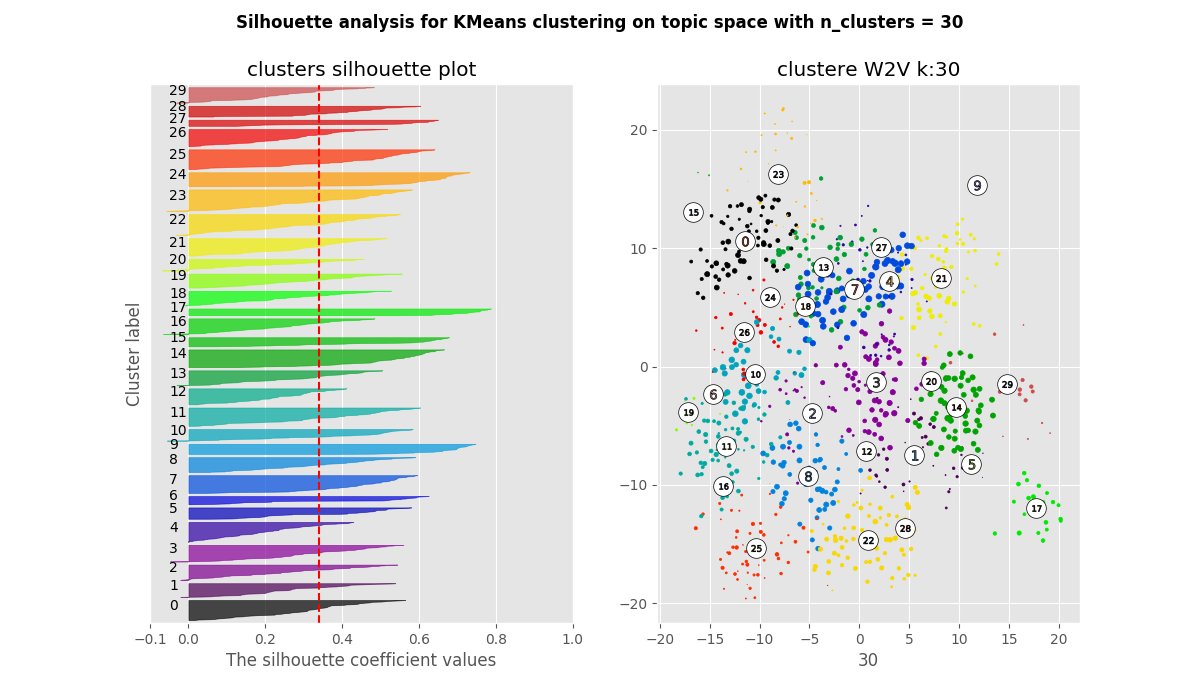

For n_clusters = 30 The average silhouette_score is : 0.340386747146


/usr/local/lib/python3.5/dist-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<IPython.core.display.Javascript object>


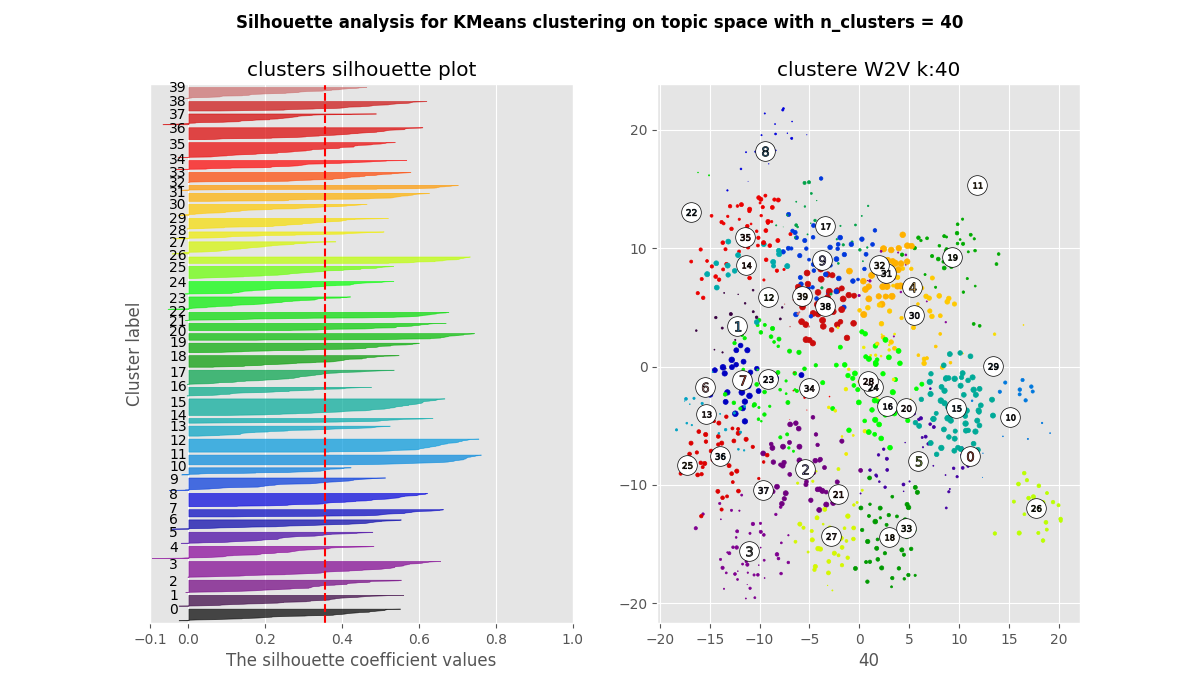

For n_clusters = 40 The average silhouette_score is : 0.355603028038


<IPython.core.display.Javascript object>


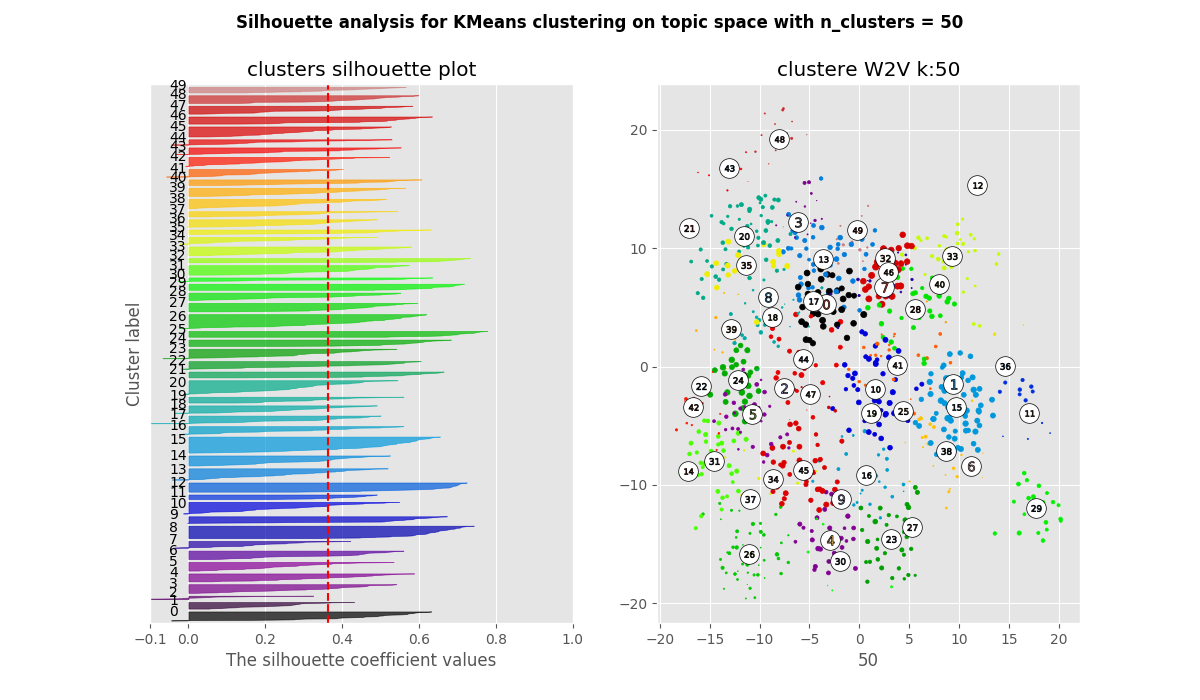

For n_clusters = 50 The average silhouette_score is : 0.364453787019


<IPython.core.display.Javascript object>


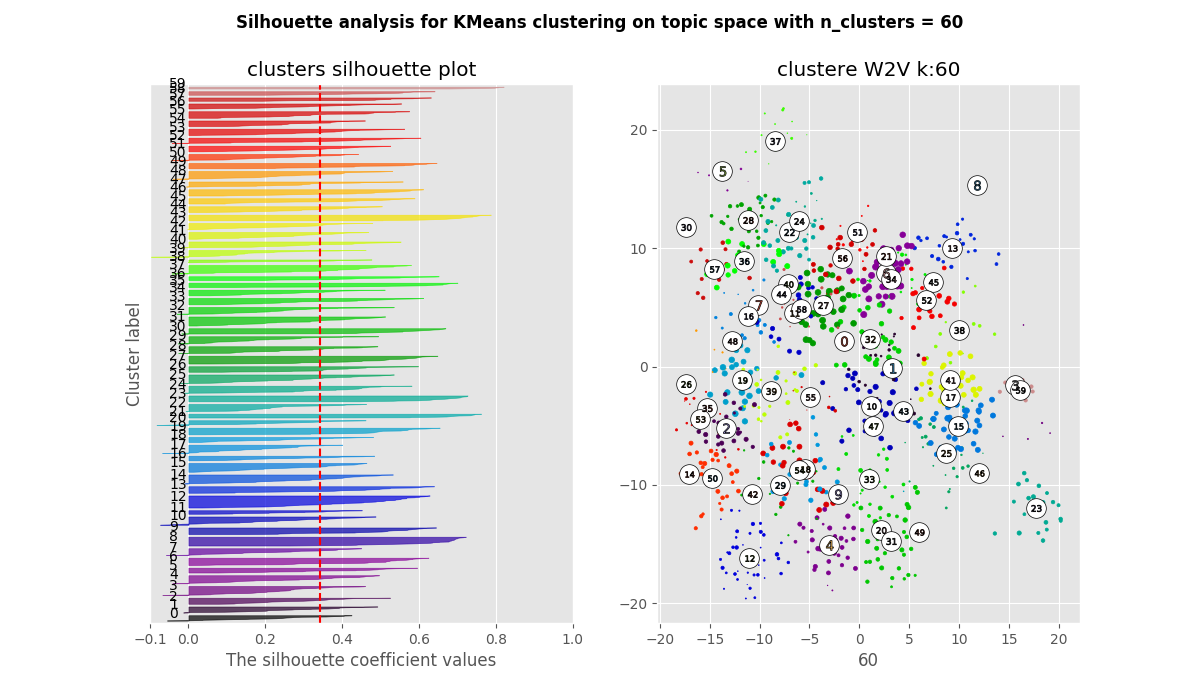

For n_clusters = 60 The average silhouette_score is : 0.342293280215


<IPython.core.display.Javascript object>


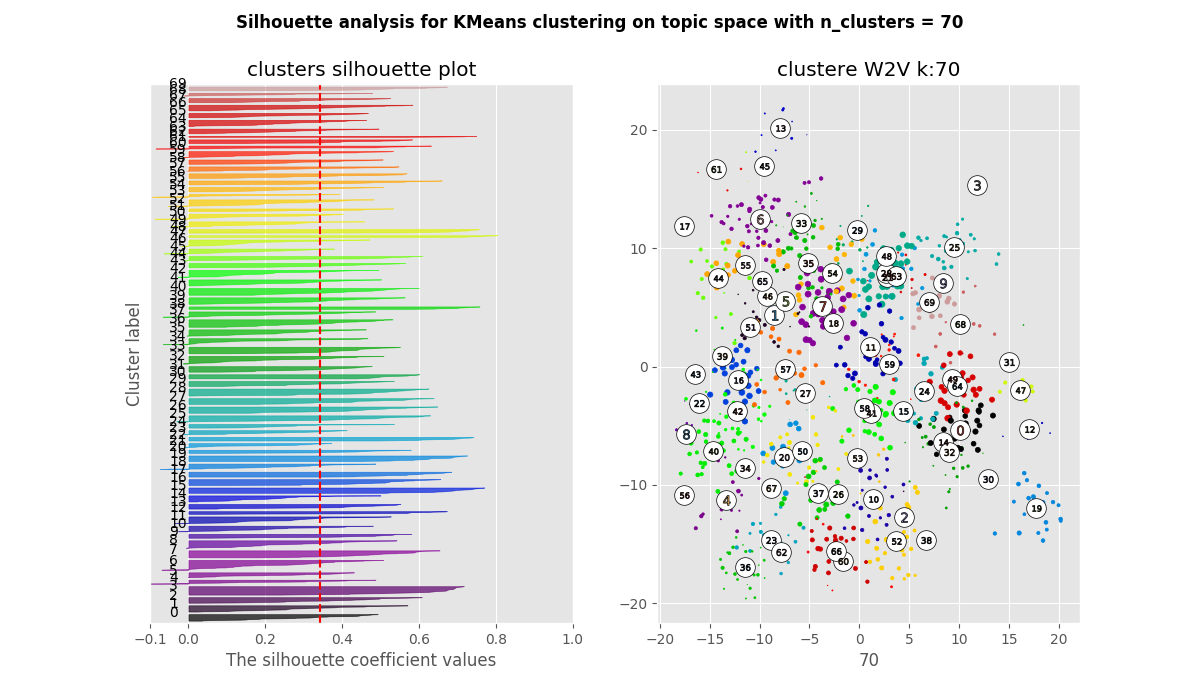

For n_clusters = 70 The average silhouette_score is : 0.341910846014
best number of clusters: 50


0         1         2        3       4  \
0  tf_idf_tokenized_window_2012_11_01         js       fjs       id    type   
1  tf_idf_tokenized_window_2012_11_02     syrian     syria      say  turkey   
2  tf_idf_tokenized_window_2012_11_03   shelling  damascus  suburbs  regime   
3  tf_idf_tokenized_window_2012_11_04     israel      gaza  israeli   hamas   
4  tf_idf_tokenized_window_2012_11_05       news       com     http     www   

             5             6             7           8            9  \
0         href          name         rferl    cssclass  link_button   
1        assad    opposition        rebels     turkish        rebel   
2        daraa        fierce  neighborhood     martyrs    artillery   
3  palestinian  palestinians          arab  gaza_strip          say   
4           in        killed          iraq        html        world   

      ...                  22            23       24                25  \
0     ...          parentnode  insertbefore   script            russia   
1     ...           coalition       foreign  patriot  president_bashar   
2     ...       demonstration          area     hama             youtu   
3     ...                  al     jerusalem    state          egyptian   
4     ...                 car      breaking       ie             feeds   

         26       27                28         29               30  \
0        3a  georgia  gulnara_karimova   document              hah   
1  fighting    month              army   activist           people   
2  warplane    wound            mortar        due             free   
3  tel_aviv       un          conflict  netanyahu        ceasefire   
4  pakistan     2012            google      wound  facebook_reddit   

  label_w2v_no  
0           36  
1           20  
2           14  
3            8  
4           34  

[5 rows x 32 columns]

CPU times: user 6.25 s, sys: 8.54 s, total: 14.8 s
Wall time: 4.92 s


In [11]:
%%time


# No scaling
# numofClusters, bestlabels = kmeans(X_embedded)
best_k, bestlabels = analyze(X_embedded, figName="W2V")
print('best number of clusters: %s' % best_k)
df['label_w2v_no'] = bestlabels
display(df.head())

<IPython.core.display.Javascript object>


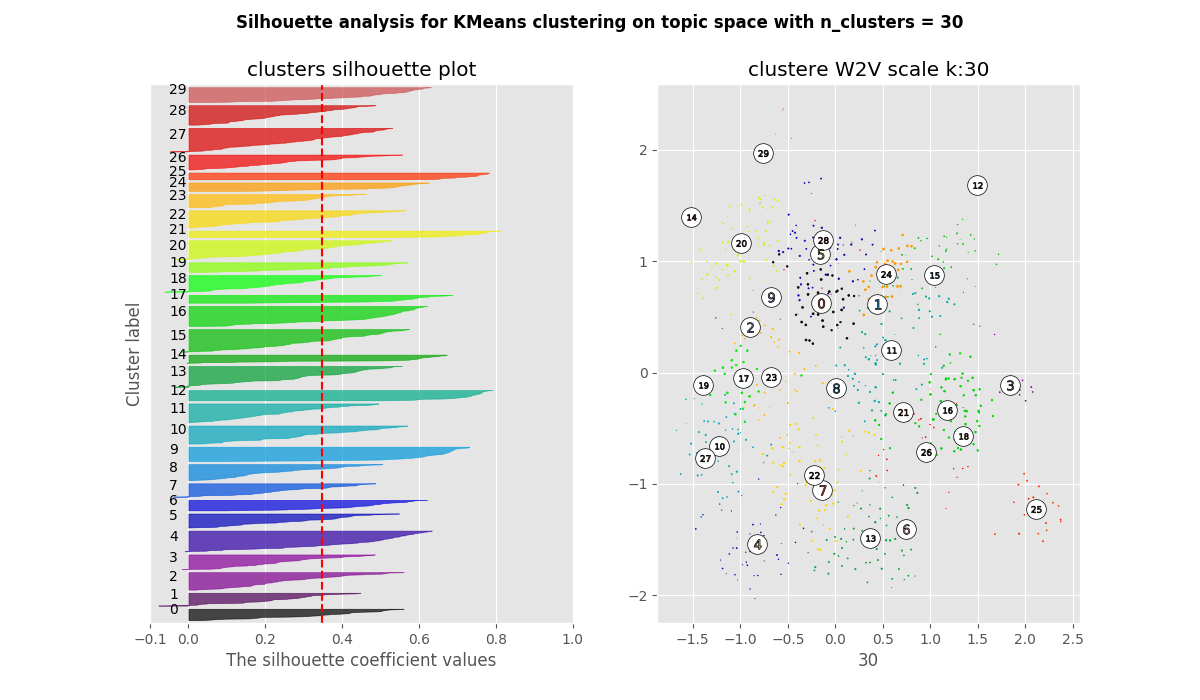

For n_clusters = 30 The average silhouette_score is : 0.346398450368


/usr/local/lib/python3.5/dist-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<IPython.core.display.Javascript object>


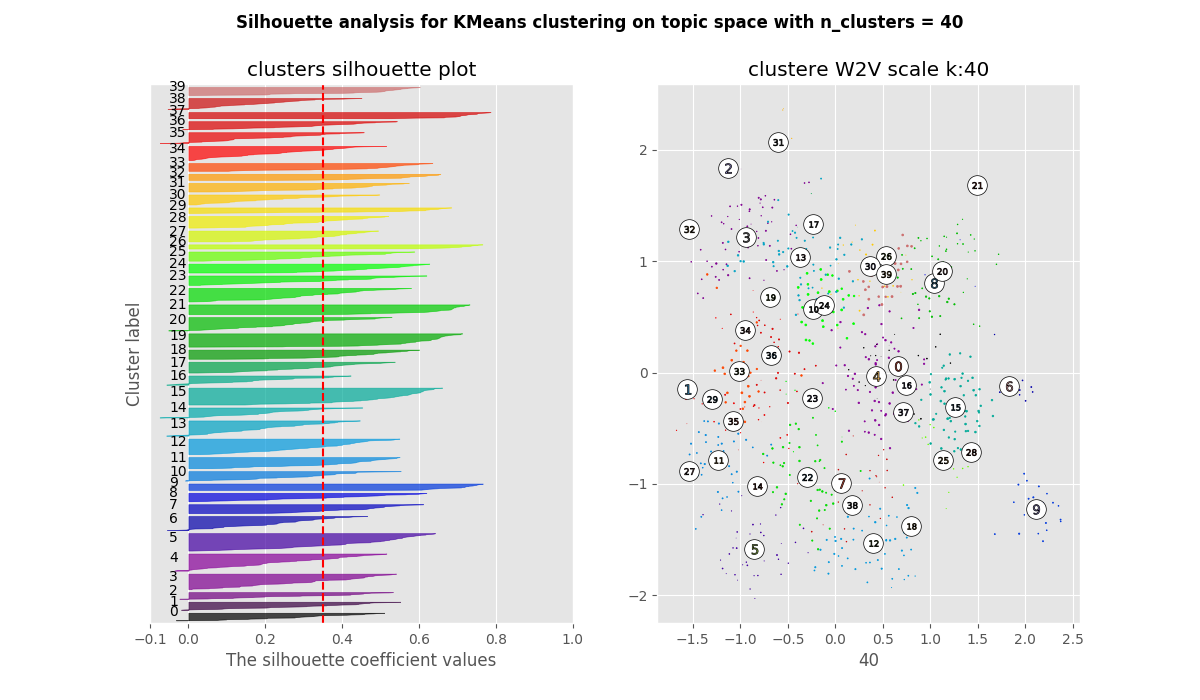

For n_clusters = 40 The average silhouette_score is : 0.349881376175


<IPython.core.display.Javascript object>


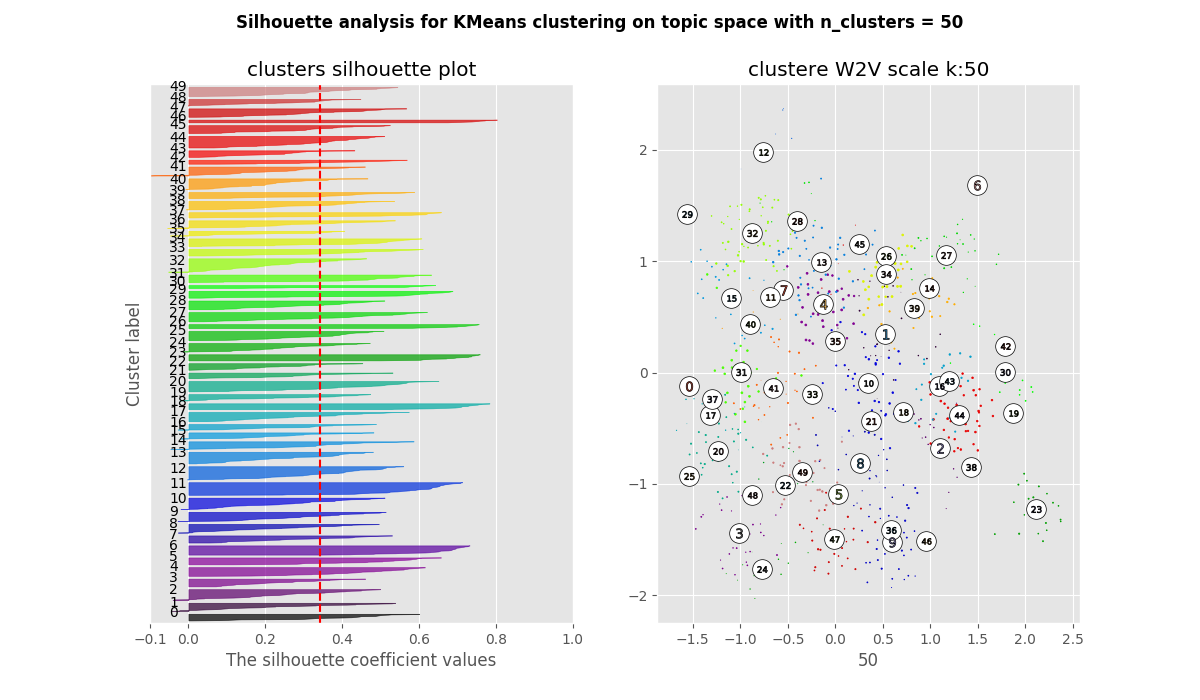

For n_clusters = 50 The average silhouette_score is : 0.342778885706


<IPython.core.display.Javascript object>


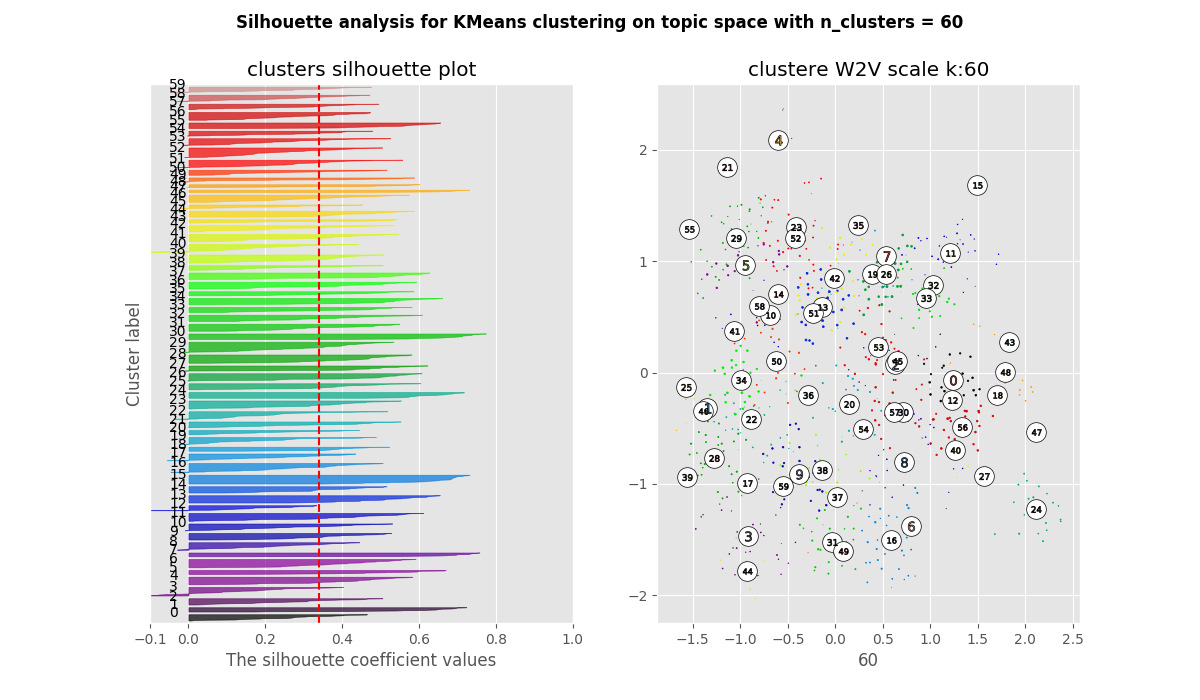

For n_clusters = 60 The average silhouette_score is : 0.339568862722


<IPython.core.display.Javascript object>


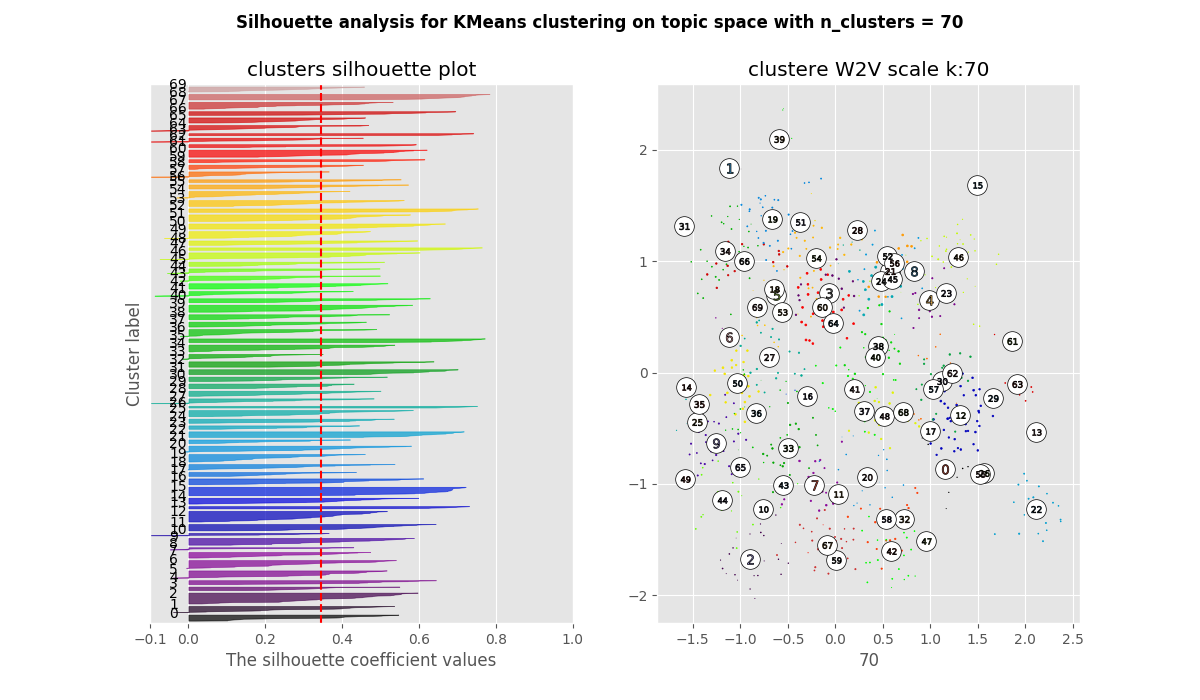

For n_clusters = 70 The average silhouette_score is : 0.345787204445
best number of clusters: 40


0         1         2        3       4  \
0  tf_idf_tokenized_window_2012_11_01         js       fjs       id    type   
1  tf_idf_tokenized_window_2012_11_02     syrian     syria      say  turkey   
2  tf_idf_tokenized_window_2012_11_03   shelling  damascus  suburbs  regime   
3  tf_idf_tokenized_window_2012_11_04     israel      gaza  israeli   hamas   
4  tf_idf_tokenized_window_2012_11_05       news       com     http     www   

             5             6             7           8            9  \
0         href          name         rferl    cssclass  link_button   
1        assad    opposition        rebels     turkish        rebel   
2        daraa        fierce  neighborhood     martyrs    artillery   
3  palestinian  palestinians          arab  gaza_strip          say   
4           in        killed          iraq        html        world   

        ...                  23       24                25        26       27  \
0       ...        insertbefore   script            russia        3a  georgia   
1       ...             foreign  patriot  president_bashar  fighting    month   
2       ...                area     hama             youtu  warplane    wound   
3       ...           jerusalem    state          egyptian  tel_aviv       un   
4       ...            breaking       ie             feeds  pakistan     2012   

                 28         29               30 label_w2v_no label_w2v_scale  
0  gulnara_karimova   document              hah           36               6  
1              army   activist           people           20               3  
2            mortar        due             free           14              27  
3          conflict  netanyahu        ceasefire            8              19  
4            google      wound  facebook_reddit           34              14  

[5 rows x 33 columns]

CPU times: user 6.7 s, sys: 9 s, total: 15.7 s
Wall time: 5.11 s


In [12]:
%%time


# Scaled
X_embedded_scaled = preprocessing.scale(X_embedded)
best_k, bestlabels = analyze(X_embedded_scaled, figName="W2V scale")
print('best number of clusters: %s' % best_k)
df['label_w2v_scale'] = bestlabels
display(df.head())

<IPython.core.display.Javascript object>


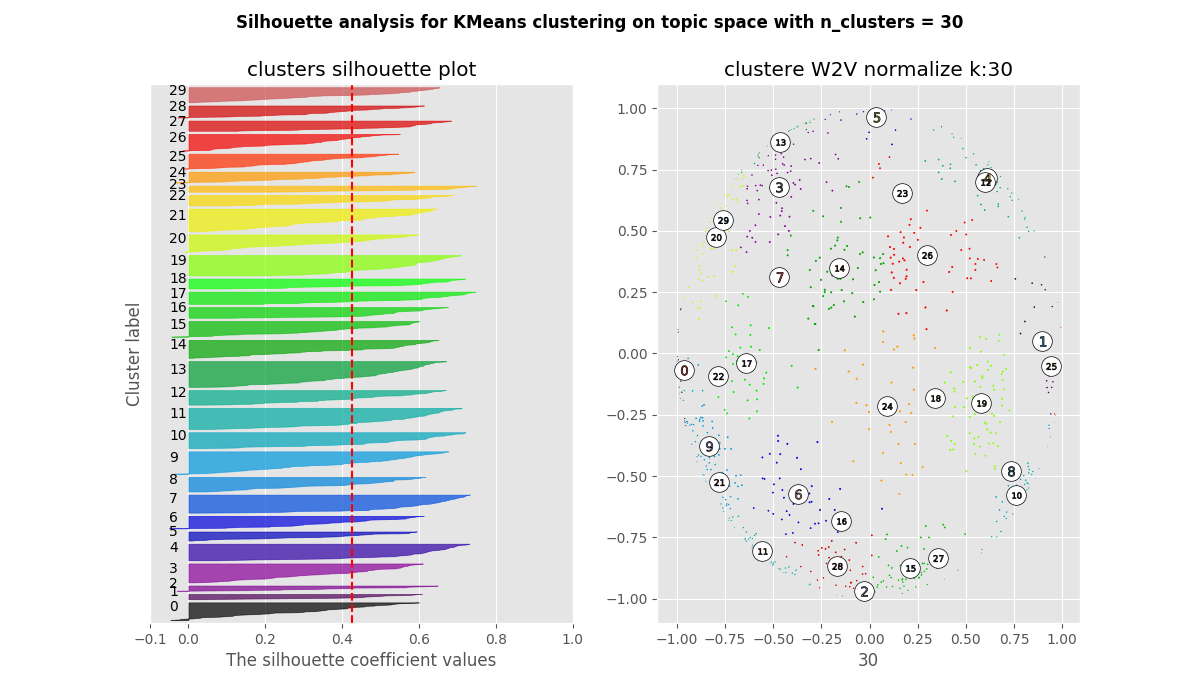

For n_clusters = 30 The average silhouette_score is : 0.425847357464


/usr/local/lib/python3.5/dist-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<IPython.core.display.Javascript object>


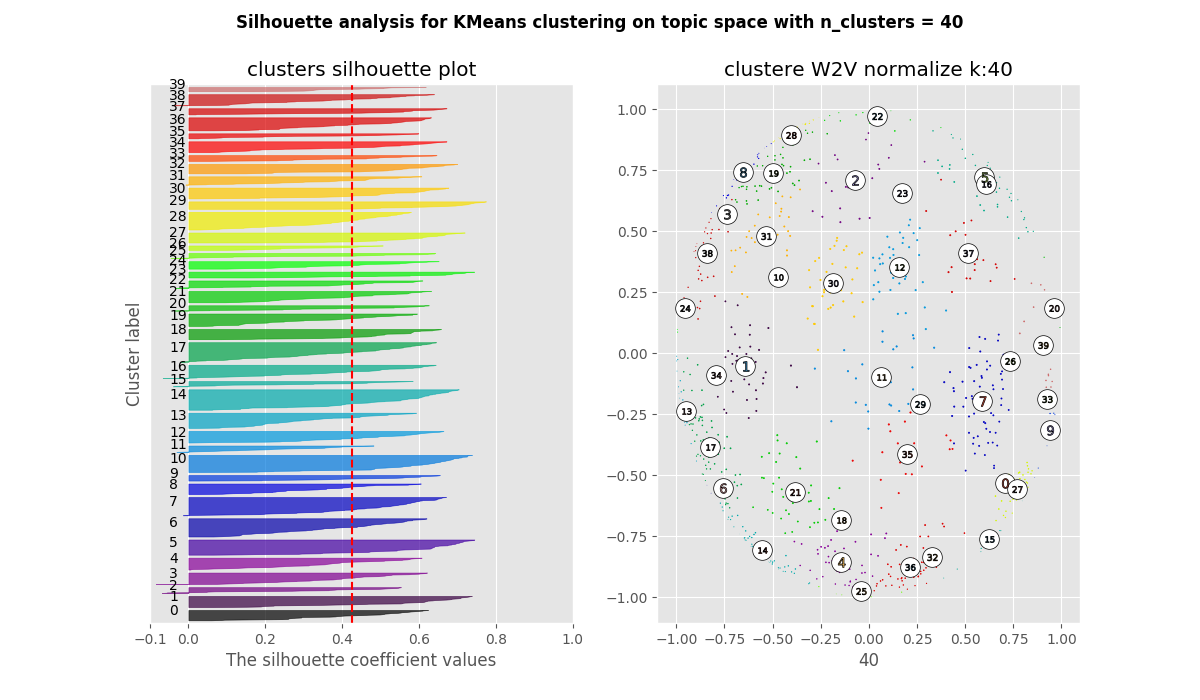

For n_clusters = 40 The average silhouette_score is : 0.425286207796


<IPython.core.display.Javascript object>


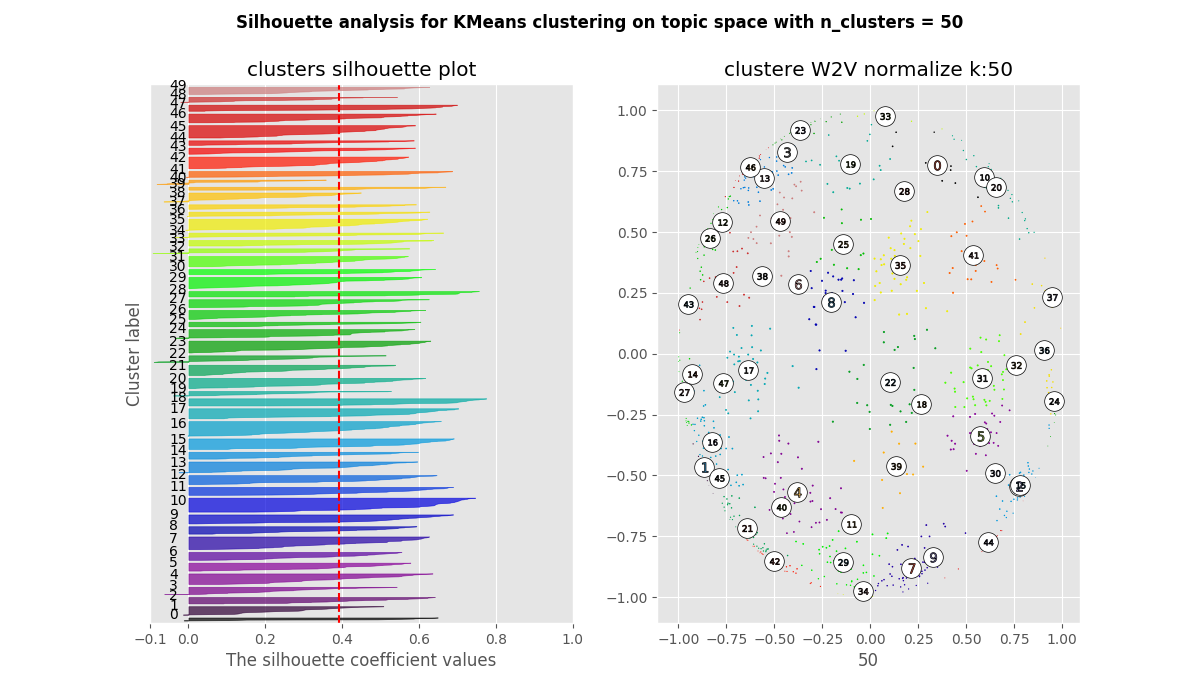

For n_clusters = 50 The average silhouette_score is : 0.392950242071


<IPython.core.display.Javascript object>


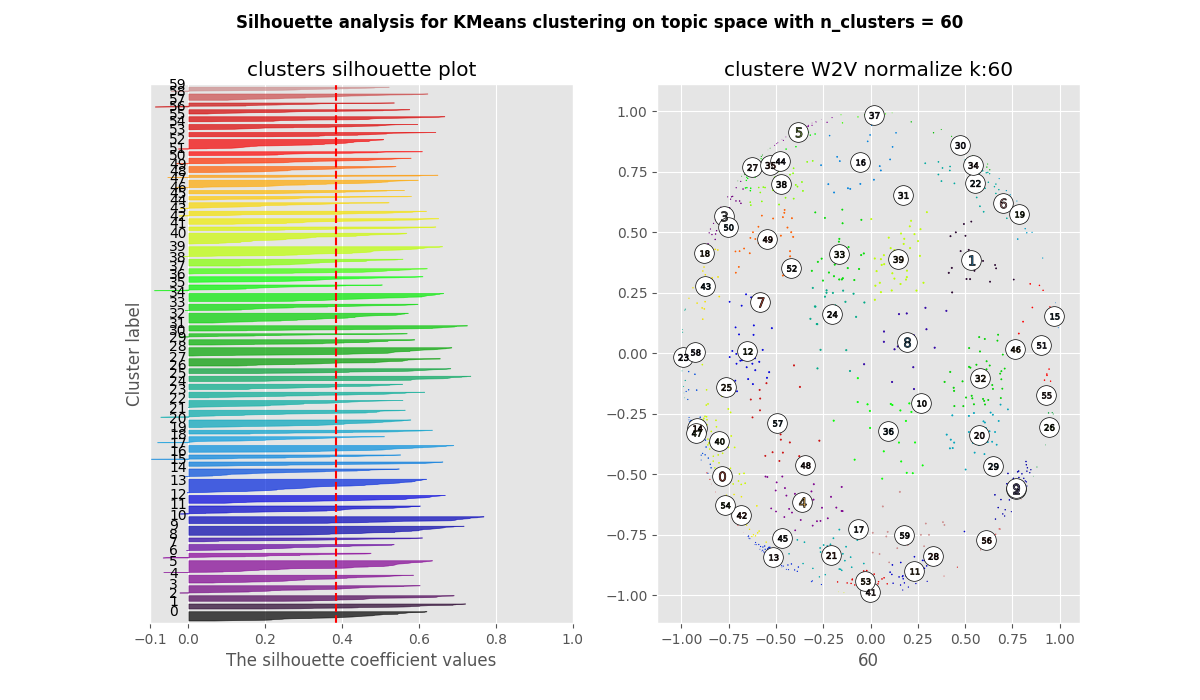

For n_clusters = 60 The average silhouette_score is : 0.382804062511


<IPython.core.display.Javascript object>


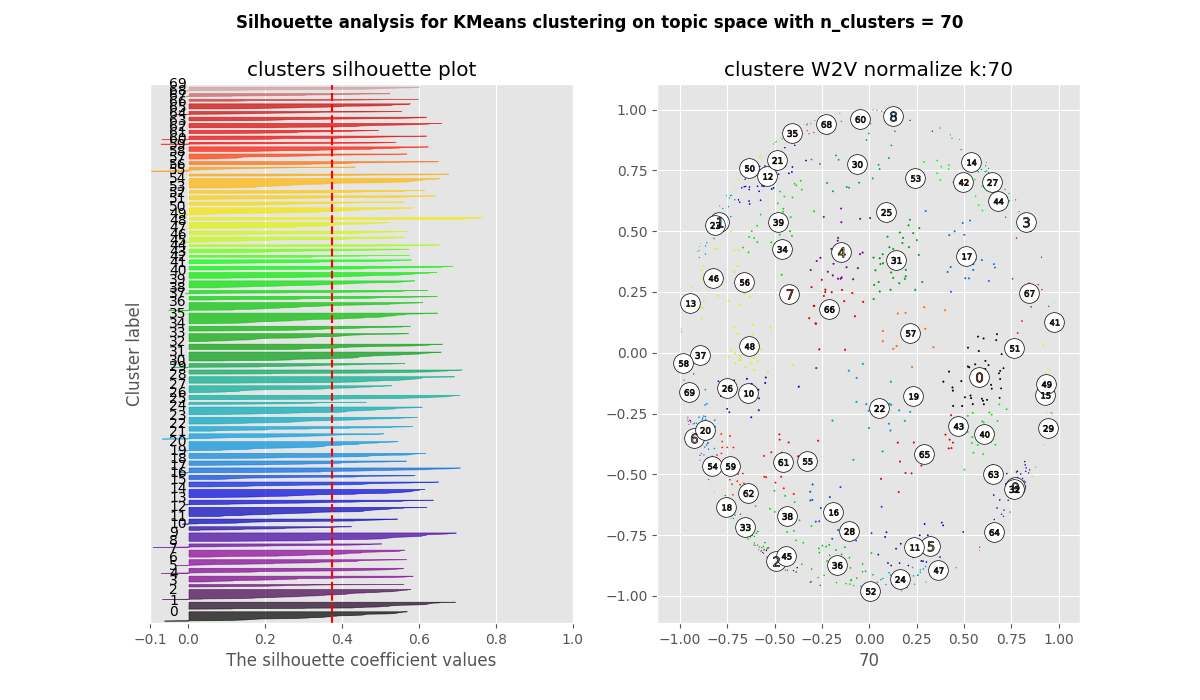

For n_clusters = 70 The average silhouette_score is : 0.372795617088
best number of clusters: 30


0         1         2        3       4  \
0  tf_idf_tokenized_window_2012_11_01         js       fjs       id    type   
1  tf_idf_tokenized_window_2012_11_02     syrian     syria      say  turkey   
2  tf_idf_tokenized_window_2012_11_03   shelling  damascus  suburbs  regime   
3  tf_idf_tokenized_window_2012_11_04     israel      gaza  israeli   hamas   
4  tf_idf_tokenized_window_2012_11_05       news       com     http     www   

             5             6             7           8            9  \
0         href          name         rferl    cssclass  link_button   
1        assad    opposition        rebels     turkish        rebel   
2        daraa        fierce  neighborhood     martyrs    artillery   
3  palestinian  palestinians          arab  gaza_strip          say   
4           in        killed          iraq        html        world   

          ...               24                25        26       27  \
0         ...           script            russia        3a  georgia   
1         ...          patriot  president_bashar  fighting    month   
2         ...             hama             youtu  warplane    wound   
3         ...            state          egyptian  tel_aviv       un   
4         ...               ie             feeds  pakistan     2012   

                 28         29               30 label_w2v_no label_w2v_scale  \
0  gulnara_karimova   document              hah           36               6   
1              army   activist           people           20               3   
2            mortar        due             free           14              27   
3          conflict  netanyahu        ceasefire            8              19   
4            google      wound  facebook_reddit           34              14   

  label_w2v_normalize  
0                  25  
1                  20  
2                  21  
3                   7  
4                  21  

[5 rows x 34 columns]

CPU times: user 6.51 s, sys: 8.96 s, total: 15.5 s
Wall time: 5.07 s


In [13]:
%%time


# Normalized 
X_normalized = preprocessing.normalize(X_embedded, norm='l2')
best_k, bestlabels = analyze(X_normalized, figName="W2V normalize")
print('best number of clusters: %s' % best_k)
df['label_w2v_normalize'] = bestlabels
display(df.head())

# Word Mover's Distance

In [14]:
X_wmd_distance_eos = pd.read_pickle('data/df_X_wmd_distance_eos.plk')
# print(X_wmd_distance_eos)

X_wmd_distance_eos = TSNE(n_components=3, init='pca', verbose=2).fit_transform(X_wmd_distance_eos)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1546
[t-SNE] Computed conditional probabilities for sample 1546 / 1546
[t-SNE] Mean sigma: 1.001407
[t-SNE] Iteration 25: error = 1.4322207, gradient norm = 0.0227097
[t-SNE] Iteration 50: error = 1.2940395, gradient norm = 0.0184377
[t-SNE] Iteration 75: error = 1.0870367, gradient norm = 0.0099298
[t-SNE] Iteration 100: error = 1.0724896, gradient norm = 0.0119170
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.072490
[t-SNE] Iteration 125: error = 1.0104851, gradient norm = 0.0077116
[t-SNE] Iteration 150: error = 1.0190333, gradient norm = 0.0105304
[t-SNE] Iteration 175: error = 1.0037144, gradient norm = 0.0107932
[t-SNE] Iteration 200: error = 0.9737310, gradient norm = 0.0110103
[t-SNE] Iteration 225: error = 0.9447153, gradient norm = 0.0105912
[t-SNE] Iteration 250: error = 0.9243681, gradient norm = 0.0106318
[t-

<IPython.core.display.Javascript object>


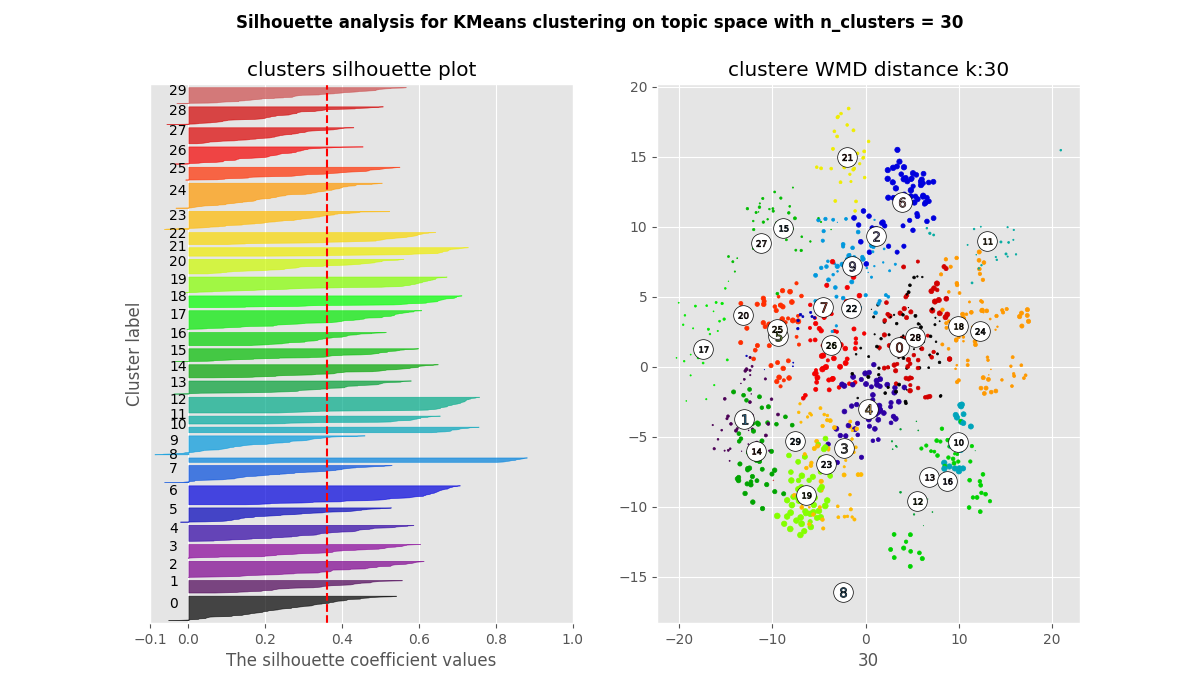

For n_clusters = 30 The average silhouette_score is : 0.359614723431


/usr/local/lib/python3.5/dist-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<IPython.core.display.Javascript object>


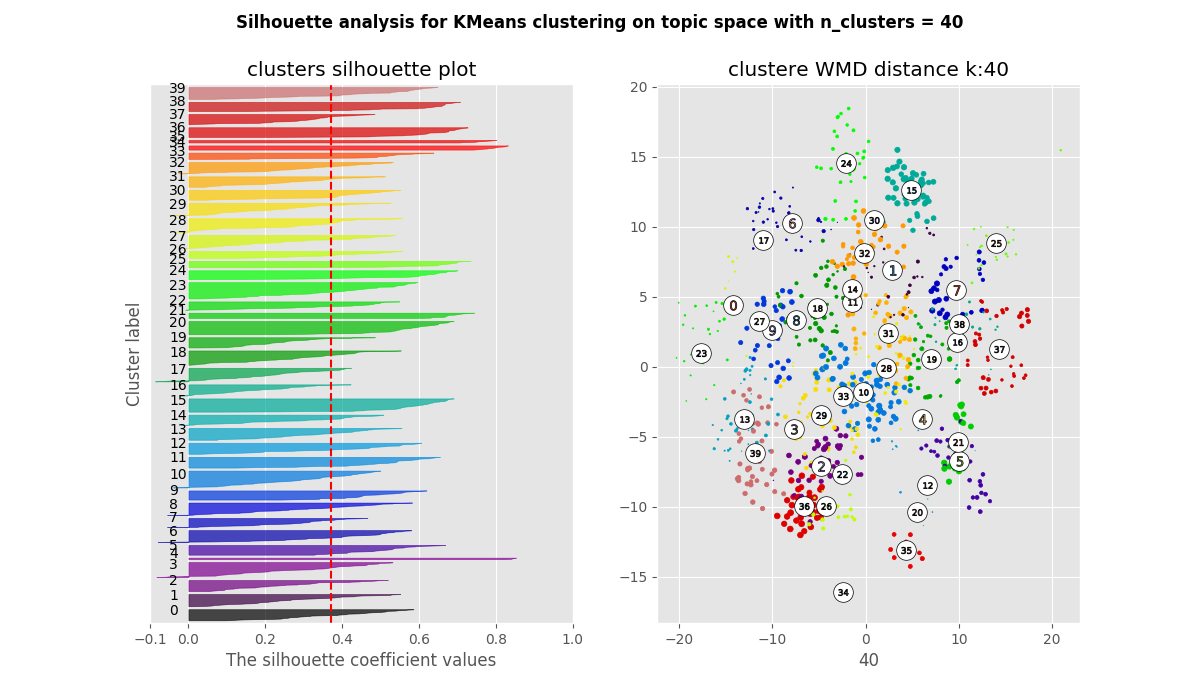

For n_clusters = 40 The average silhouette_score is : 0.369713484049


<IPython.core.display.Javascript object>


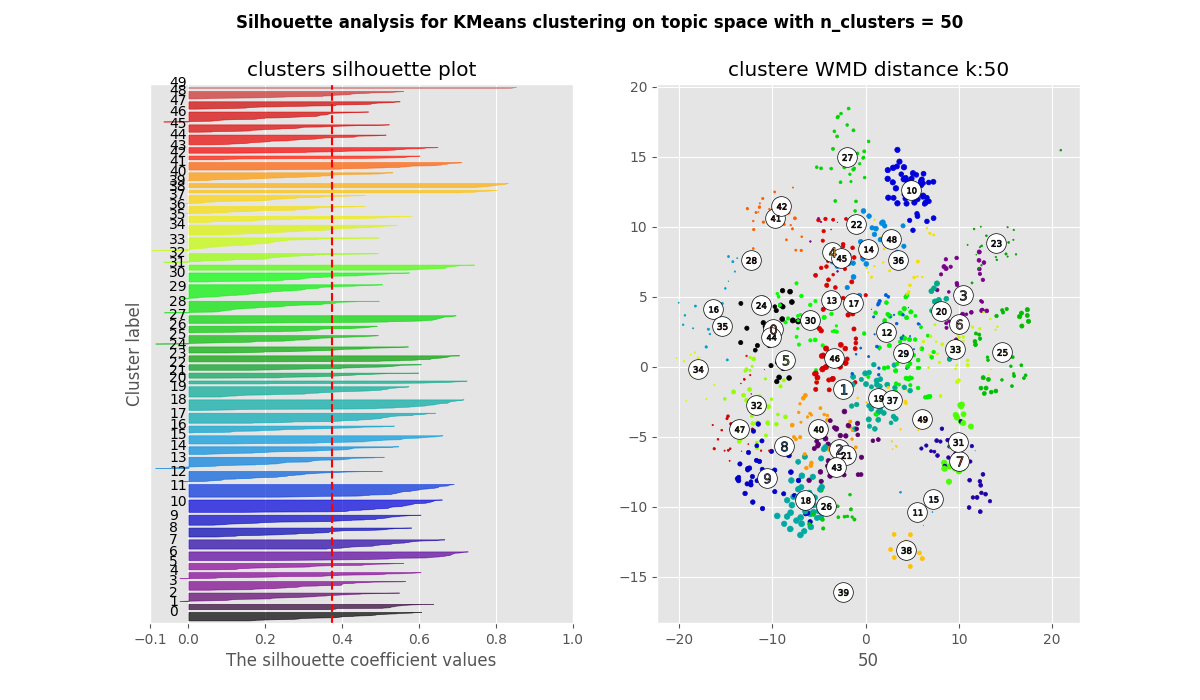

For n_clusters = 50 The average silhouette_score is : 0.374482685379


<IPython.core.display.Javascript object>


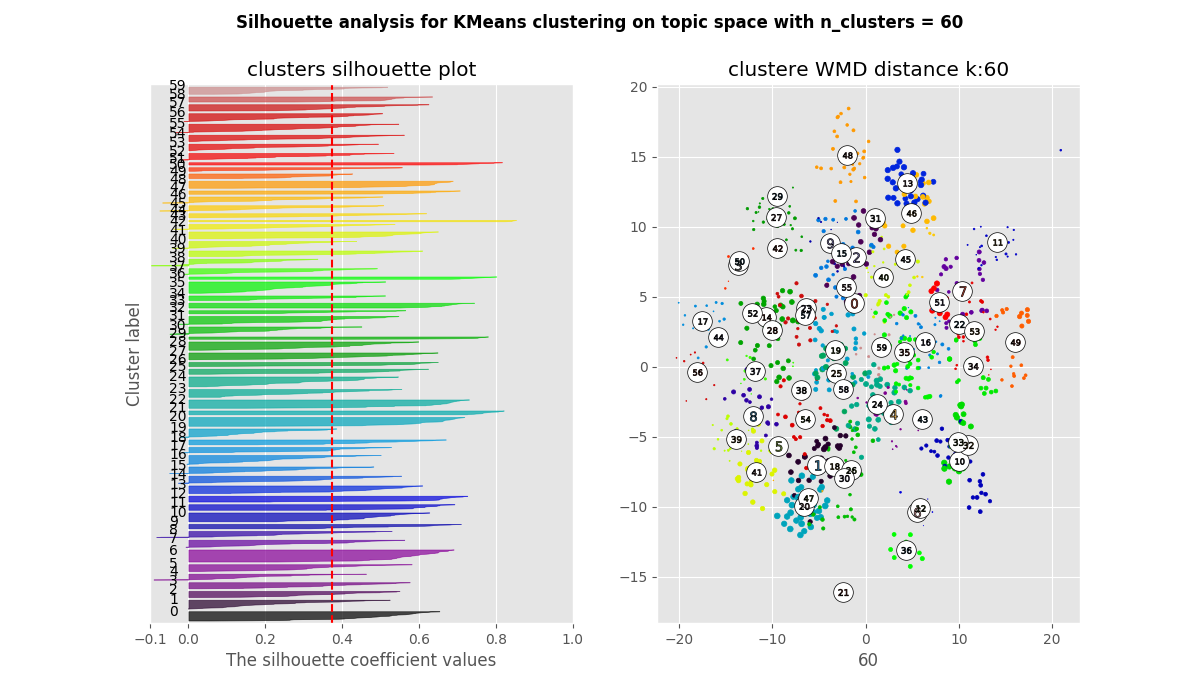

For n_clusters = 60 The average silhouette_score is : 0.374255032651


<IPython.core.display.Javascript object>


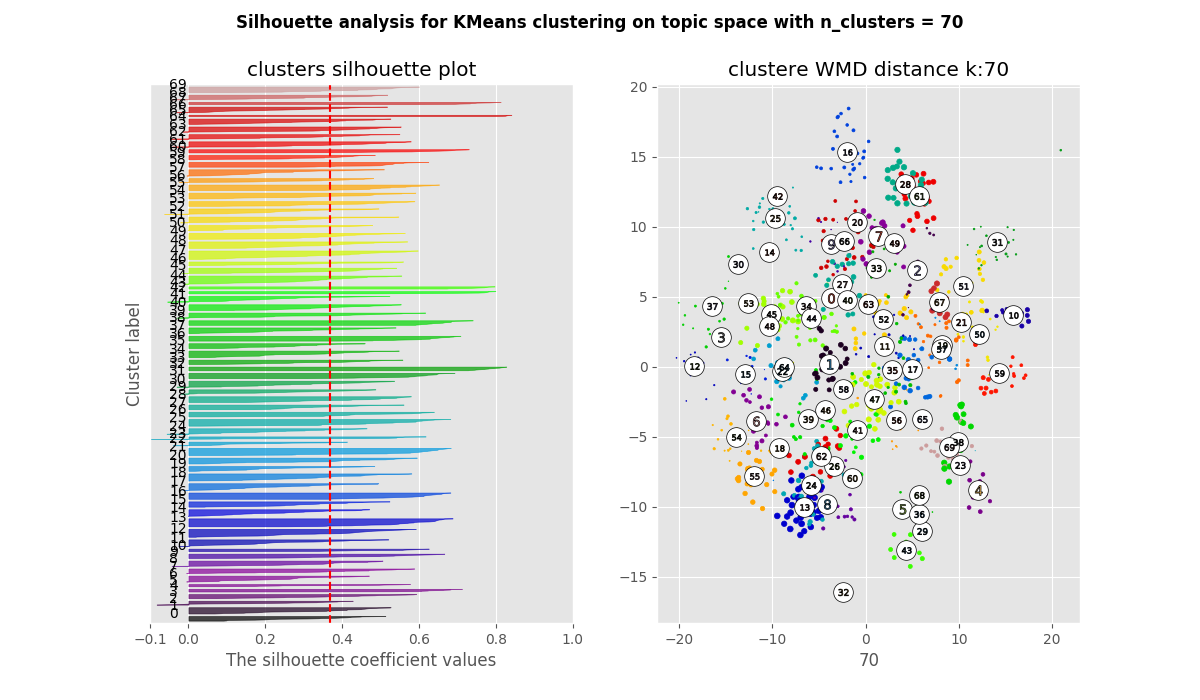

For n_clusters = 70 The average silhouette_score is : 0.368823915341
best number of clusters: 50


0         1         2        3       4  \
0  tf_idf_tokenized_window_2012_11_01         js       fjs       id    type   
1  tf_idf_tokenized_window_2012_11_02     syrian     syria      say  turkey   
2  tf_idf_tokenized_window_2012_11_03   shelling  damascus  suburbs  regime   
3  tf_idf_tokenized_window_2012_11_04     israel      gaza  israeli   hamas   
4  tf_idf_tokenized_window_2012_11_05       news       com     http     www   

             5             6             7           8            9  \
0         href          name         rferl    cssclass  link_button   
1        assad    opposition        rebels     turkish        rebel   
2        daraa        fierce  neighborhood     martyrs    artillery   
3  palestinian  palestinians          arab  gaza_strip          say   
4           in        killed          iraq        html        world   

         ...                        25        26       27                28  \
0        ...                    russia        3a  georgia  gulnara_karimova   
1        ...          president_bashar  fighting    month              army   
2        ...                     youtu  warplane    wound            mortar   
3        ...                  egyptian  tel_aviv       un          conflict   
4        ...                     feeds  pakistan     2012            google   

          29               30 label_w2v_no label_w2v_scale  \
0   document              hah           36               6   
1   activist           people           20               3   
2        due             free           14              27   
3  netanyahu        ceasefire            8              19   
4      wound  facebook_reddit           34              14   

  label_w2v_normalize label_wmd_distance  
0                  25                 25  
1                  20                 35  
2                  21                 26  
3                   7                 11  
4                  21                  2  

[5 rows x 35 columns]

In [15]:
# Pairewise distance
best_k, bestlabels = analyze(X_wmd_distance_eos, figName="WMD distance")
print('best number of clusters: %s' % best_k)
df['label_wmd_distance'] = bestlabels

display(df.head())

In [16]:
display(df.loc[df['label_wmd_distance'] == 5].head())

0        1           2        3  \
274  tf_idf_tokenized_window_2016_12_17     putin      russia  russian   
317  tf_idf_tokenized_window_2012_06_06   turkish      turkey    plane   
322  tf_idf_tokenized_window_2012_06_11    russia  helicopter    syria   
375  tf_idf_tokenized_window_2016_04_14   russian      russia    putin   
413  tf_idf_tokenized_window_2016_09_30    russia       putin  russian   

           4         5         6         7        8                   9  \
274      say  military    moscow      nato  nuclear              shoigu   
317   syrian       jet     syria  airspace      say                nato   
322  russian      ship       say    moscow   lavrov                 arm   
375   moscow   ukraine  military   kremlin    syria            aircraft   
413   moscow   ukraine   kremlin     syria    assad  president_vladimir   

           ...                 25        26             27            28  \
274        ...             strong    crimea         threat          year   
317        ...                fly  warplane       response       meeting   
322        ...             vessel    repair       conflict          port   
375        ...          netanyahu    syrian       official  coordination   
413        ...               vote  relation  united_states        accuse   

               29       30 label_w2v_no label_w2v_scale label_w2v_normalize  \
274     aggressor    peace            3              17                  13   
317  recep_tayyip  violate           17              10                  29   
322       british     stop           17              10                   7   
375    washington     ship           17              10                  29   
413           may    print            3              17                  13   

    label_wmd_distance  
274                  5  
317                  5  
322                  5  
375                  5  
413                  5  

[5 rows x 35 columns]

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


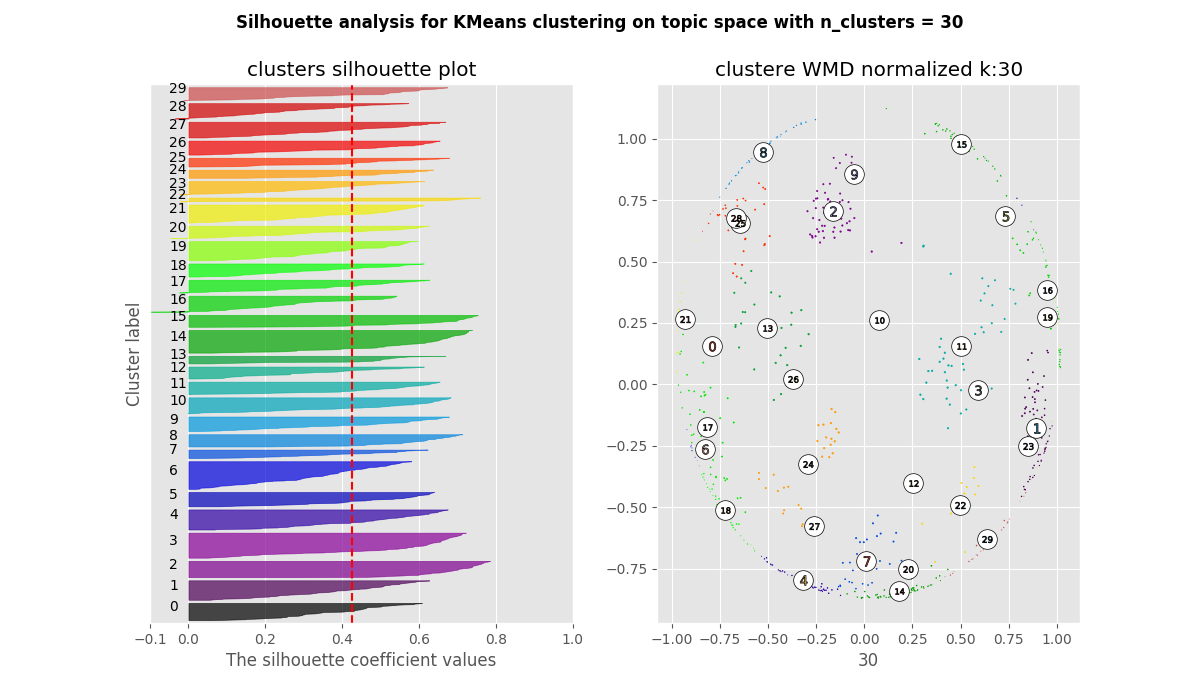

For n_clusters = 30 The average silhouette_score is : 0.426789669373


/usr/local/lib/python3.5/dist-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<IPython.core.display.Javascript object>


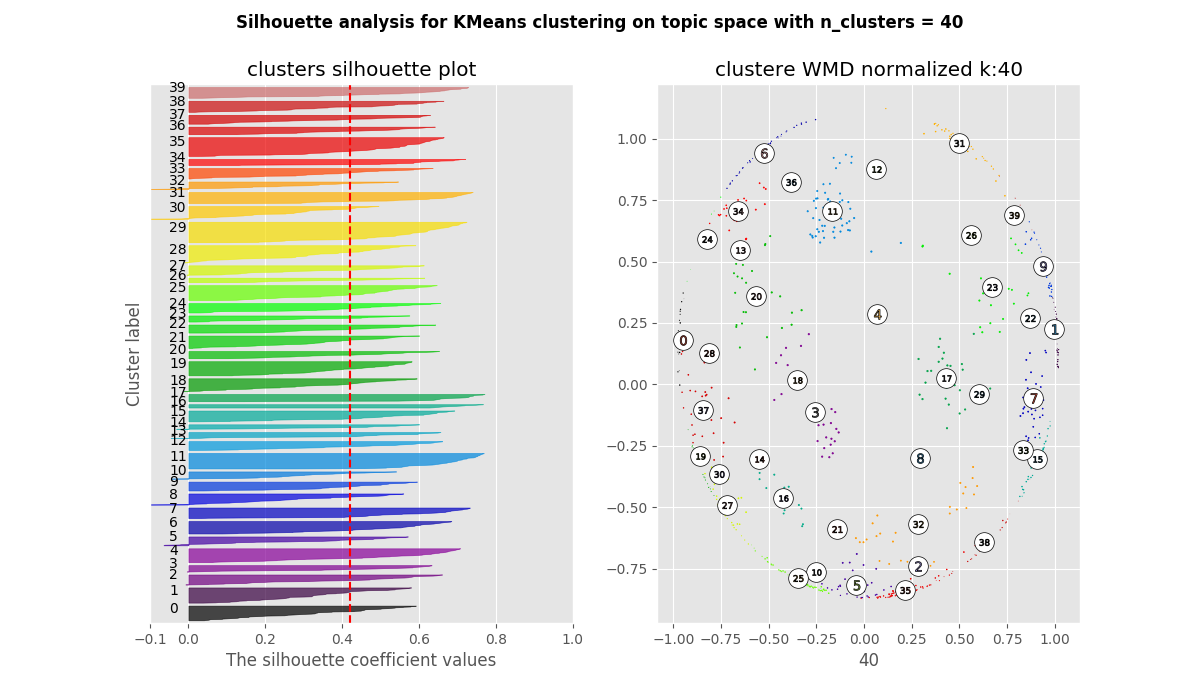

For n_clusters = 40 The average silhouette_score is : 0.421204624843


<IPython.core.display.Javascript object>


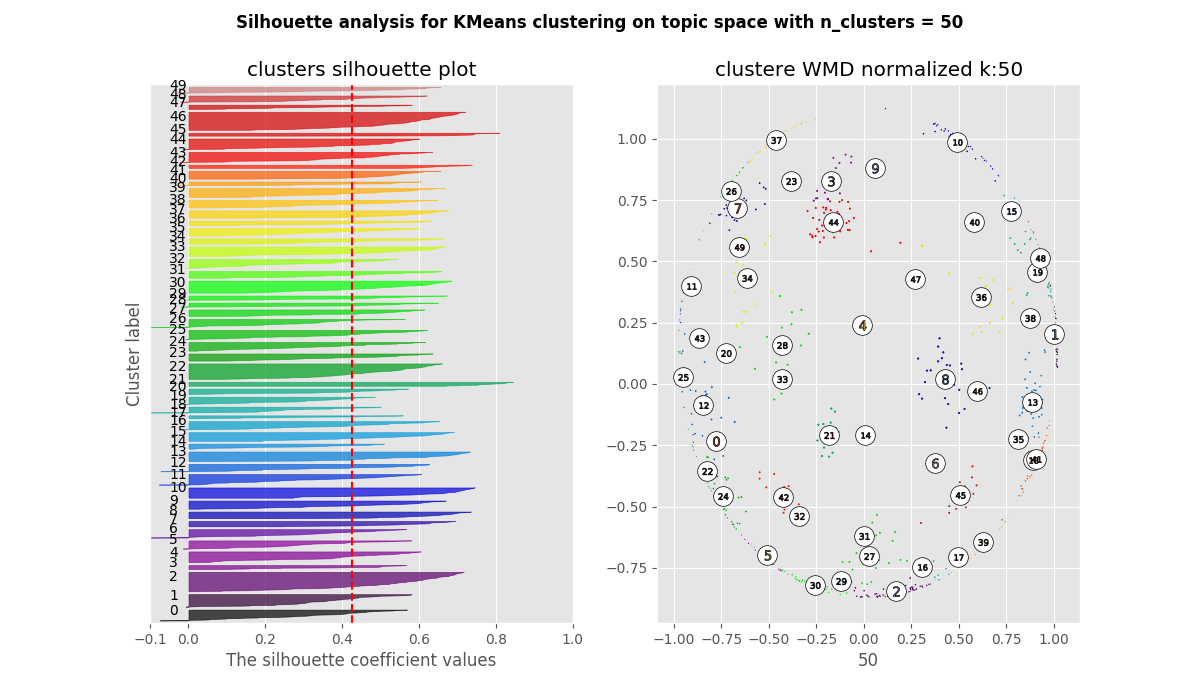

For n_clusters = 50 The average silhouette_score is : 0.425255270425


<IPython.core.display.Javascript object>


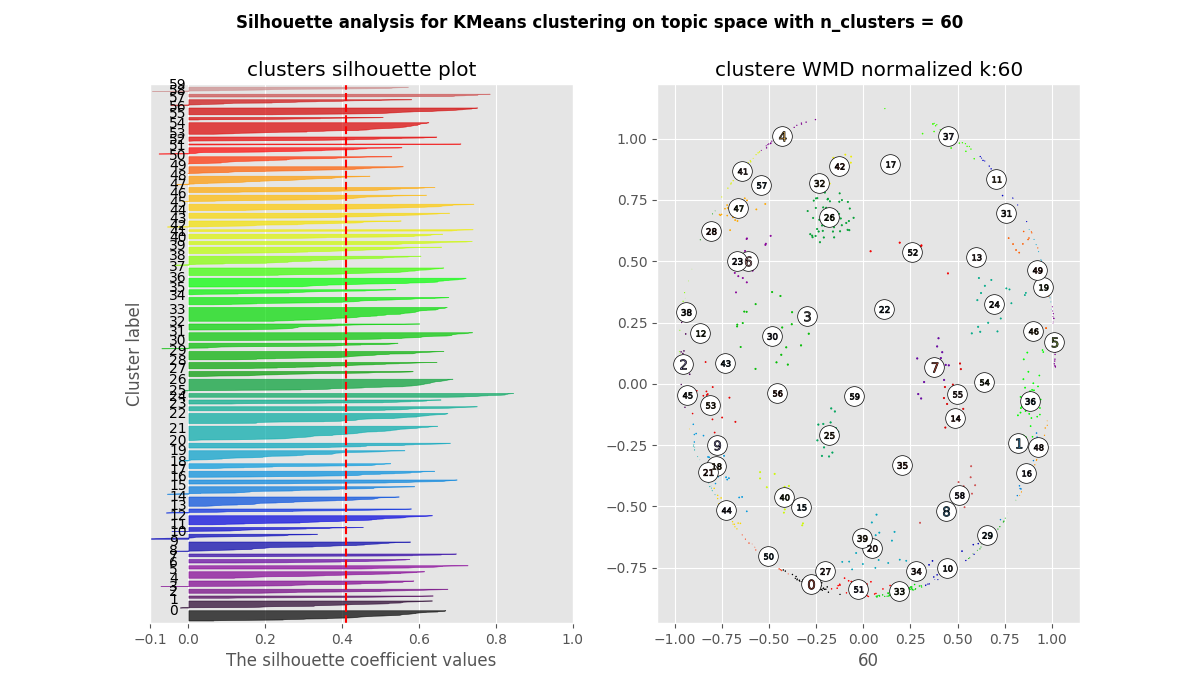

For n_clusters = 60 The average silhouette_score is : 0.409730192013


<IPython.core.display.Javascript object>


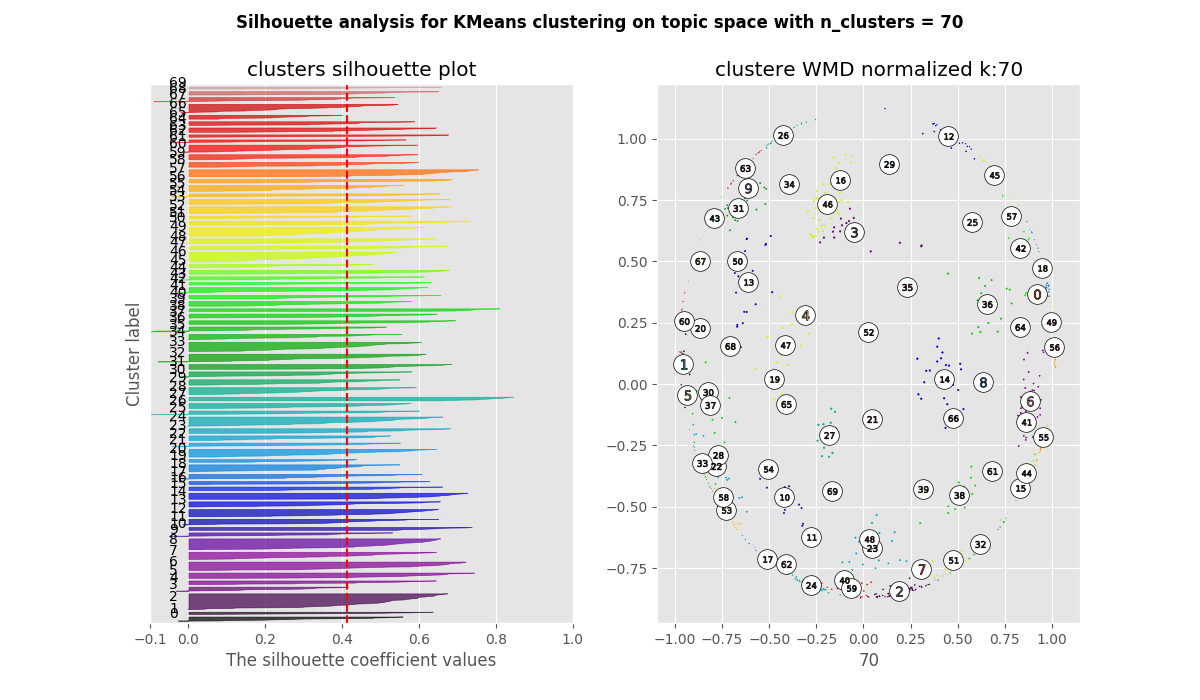

For n_clusters = 70 The average silhouette_score is : 0.411370124992
best number of clusters: 30


In [17]:
# Normalized 
X_wmd_normalized = preprocessing.normalize(X_wmd_distance_eos, norm='l2')

pca = PCA(n_components=3)
pca.fit(X_wmd_normalized)
X_wmd_normalized = pca.transform(X_wmd_normalized)

best_k, bestlabels = analyze(X_wmd_normalized,  figName="WMD normalized")
print('best number of clusters: %s' % best_k)
df['label_wmd_normalize'] = bestlabels

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


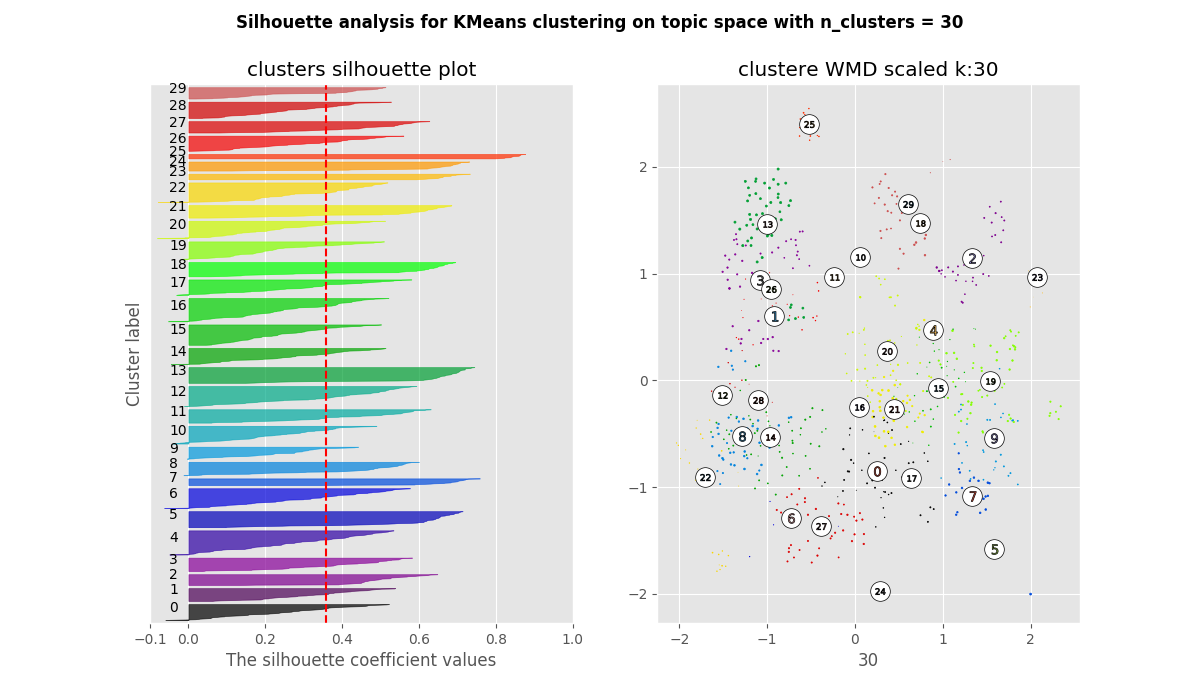

For n_clusters = 30 The average silhouette_score is : 0.356698250569


/usr/local/lib/python3.5/dist-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<IPython.core.display.Javascript object>


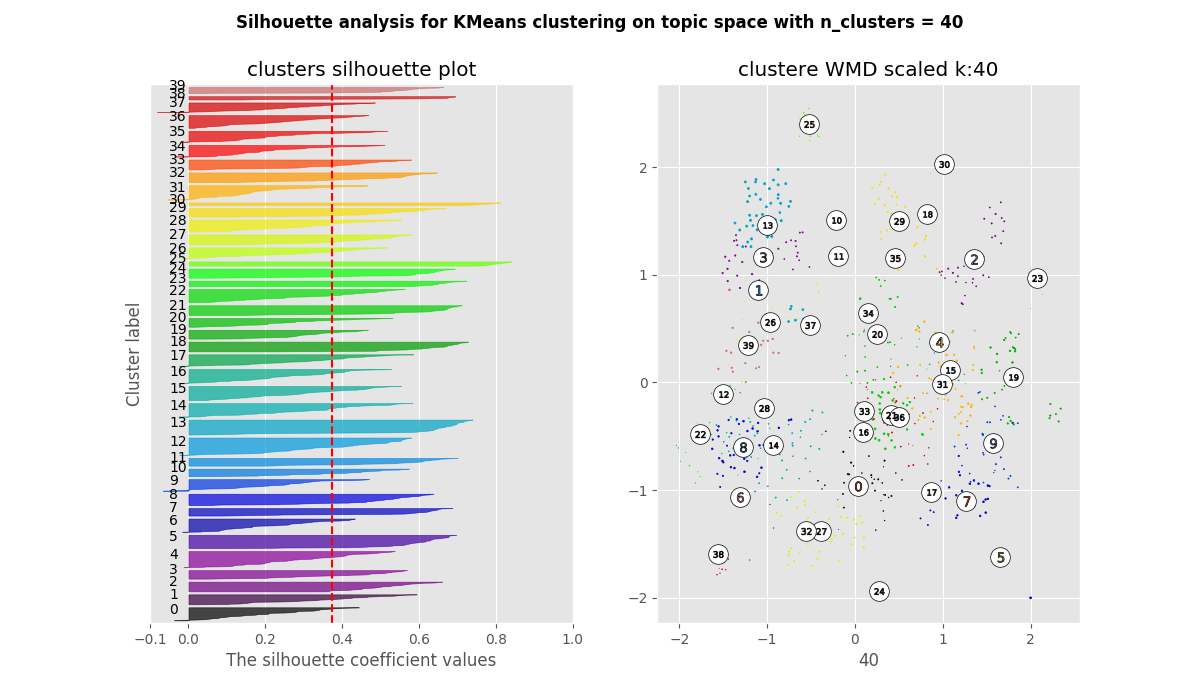

For n_clusters = 40 The average silhouette_score is : 0.373808434184


<IPython.core.display.Javascript object>


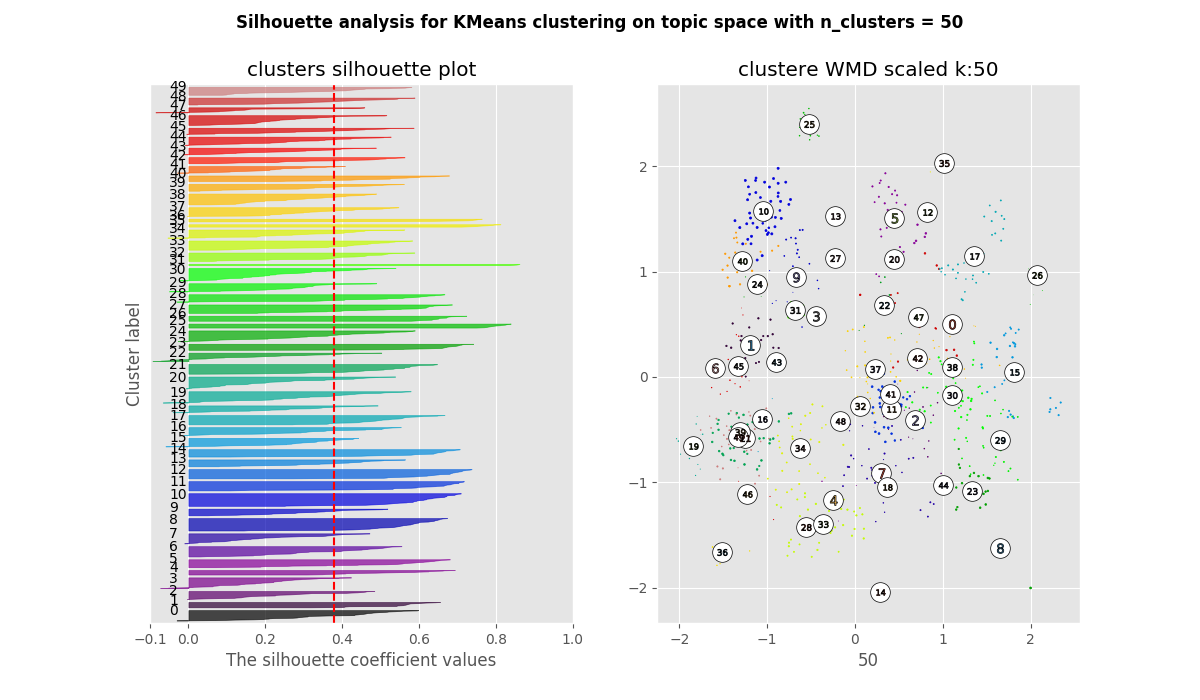

For n_clusters = 50 The average silhouette_score is : 0.378579693242


<IPython.core.display.Javascript object>


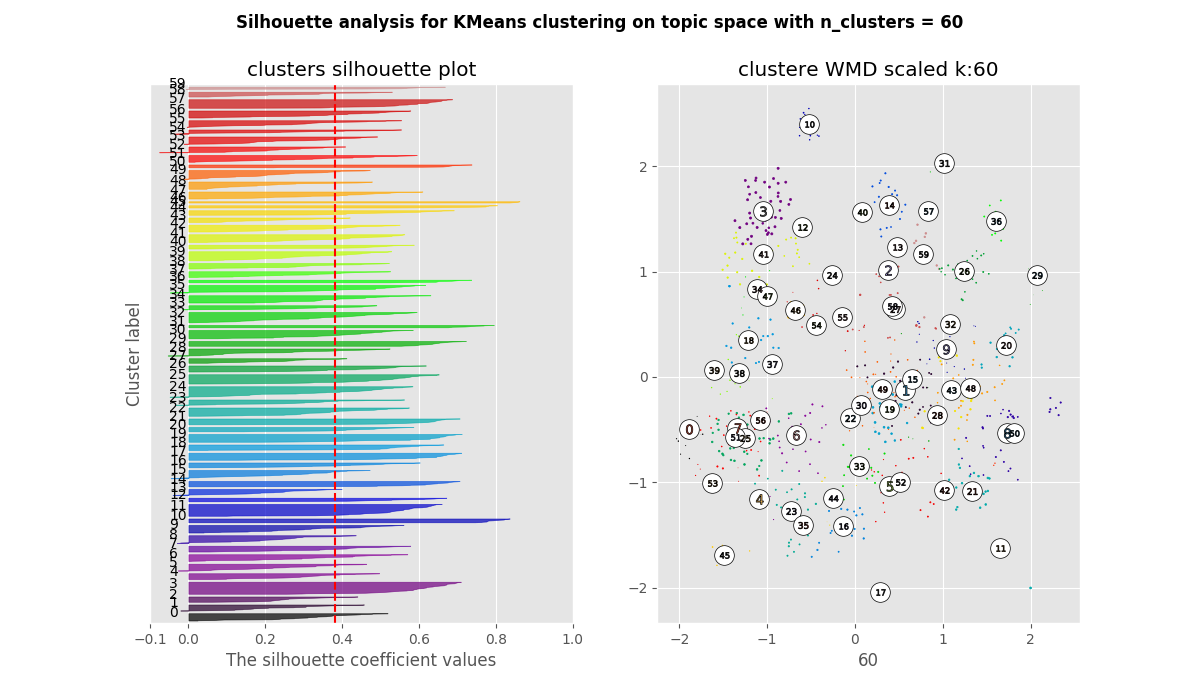

For n_clusters = 60 The average silhouette_score is : 0.382404378202


<IPython.core.display.Javascript object>


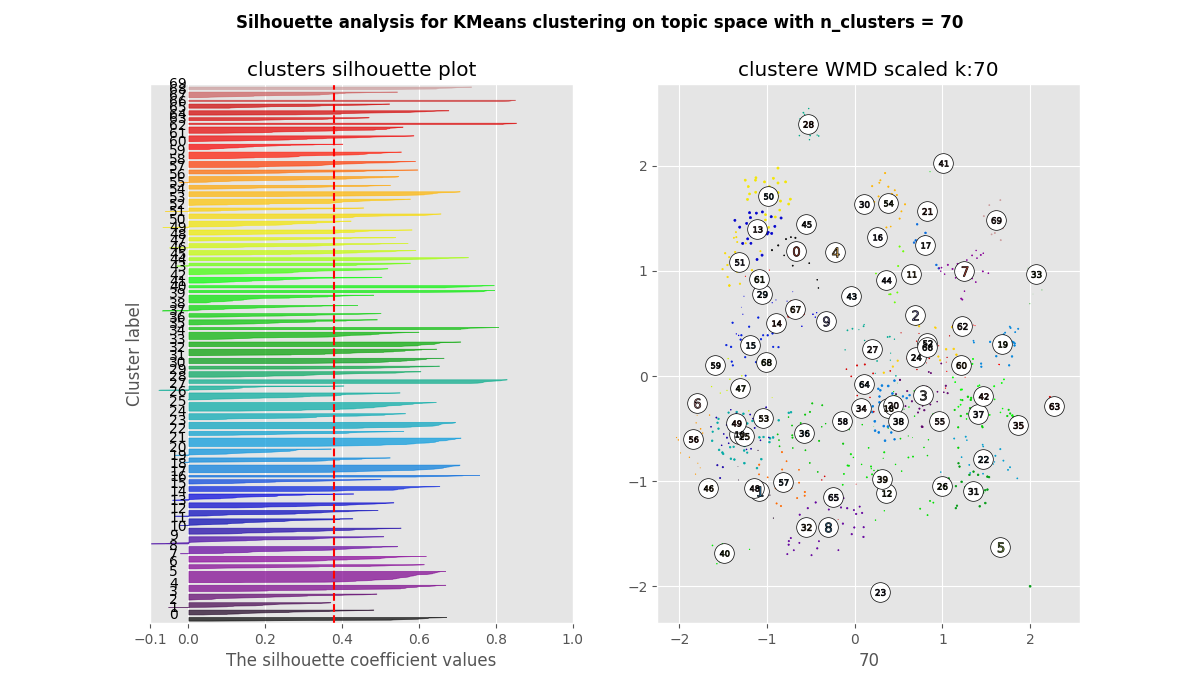

For n_clusters = 70 The average silhouette_score is : 0.377502397647


0         1         2        3       4  \
0  tf_idf_tokenized_window_2012_11_01         js       fjs       id    type   
1  tf_idf_tokenized_window_2012_11_02     syrian     syria      say  turkey   
2  tf_idf_tokenized_window_2012_11_03   shelling  damascus  suburbs  regime   
3  tf_idf_tokenized_window_2012_11_04     israel      gaza  israeli   hamas   
4  tf_idf_tokenized_window_2012_11_05       news       com     http     www   

             5             6             7           8            9  \
0         href          name         rferl    cssclass  link_button   
1        assad    opposition        rebels     turkish        rebel   
2        daraa        fierce  neighborhood     martyrs    artillery   
3  palestinian  palestinians          arab  gaza_strip          say   
4           in        killed          iraq        html        world   

        ...             27                28         29               30  \
0       ...        georgia  gulnara_karimova   document              hah   
1       ...          month              army   activist           people   
2       ...          wound            mortar        due             free   
3       ...             un          conflict  netanyahu        ceasefire   
4       ...           2012            google      wound  facebook_reddit   

  label_w2v_no label_w2v_scale label_w2v_normalize label_wmd_distance  \
0           36               6                  25                 25   
1           20               3                  20                 35   
2           14              27                  21                 26   
3            8              19                   7                 11   
4           34              14                  21                  2   

  label_wmd_normalize label_wmd_scale  
0                  16              60  
1                   6              60  
2                   7              60  
3                   2              60  
4                  22              60  

[5 rows x 37 columns]

In [18]:
# Scaled
X_wmd_scaled = preprocessing.scale(X_wmd_distance_eos)

pca = PCA(n_components=3)
pca.fit(X_wmd_scaled)
X_wmd_scaled = pca.transform(X_wmd_scaled)

best_k, bestlabels = analyze(X_wmd_scaled, figName="WMD scaled")
df['label_wmd_scale'] = best_k
display(df.head())

# TF-IDF

In [19]:
%%time 


corpus_all  = []

for corpus_line in getCorpus():
    corpus_all.append(u' '.join(str(e) for e in corpus_line))
    
print(corpus_all[0])
    
vectorizer = CountVectorizer(max_df=0.5, min_df=5)
# vectorizer = CountVectorizer(max_df=0.5)
X_tfidf = vectorizer.fit_transform(corpus_all)  # a sparse matrix

vocab = vectorizer.get_feature_names()  # a list

print(len(vocab))

print(X_tfidf.shape)

id type href name rferl cssclass link_button 2f function facebook target var twitter russian true getelementbyid getelementsbytagname src createelement parentnode insertbefore script russia 3a georgia gulnara_karimova document hah 36 6 25 25 16 60
1614
(1546, 1614)
CPU times: user 68 ms, sys: 28 ms, total: 96 ms
Wall time: 68.7 ms


# LSA

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)



[t-SNE] Computed conditional probabilities for sample 1000 / 1546
[t-SNE] Computed conditional probabilities for sample 1546 / 1546
[t-SNE] Mean sigma: 0.247049
[t-SNE] Iteration 25: error = 1.3445078, gradient norm = 0.0219273
[t-SNE] Iteration 50: error = 1.2575742, gradient norm = 0.0188620
[t-SNE] Iteration 75: error = 1.0258642, gradient norm = 0.0092552
[t-SNE] Iteration 100: error = 0.9953162, gradient norm = 0.0115447
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.995316
[t-SNE] Iteration 125: error = 0.9432883, gradient norm = 0.0071119
[t-SNE] Iteration 150: error = 0.9443769, gradient norm = 0.0099680
[t-SNE] Iteration 175: error = 0.9219033, gradient norm = 0.0104395
[t-SNE] Iteration 200: error = 0.8945036, gradient norm = 0.0108962
[t-SNE] Iteration 225: error = 0.8704006, gradient norm = 0.0107456
[t-SNE] Iteration 250: error = 0.8362591, gradient norm = 0.0104092
[t-SNE] Iteration 275: error = 0.8115819, gradient norm = 0.0100990
[t-SNE] Iteratio

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


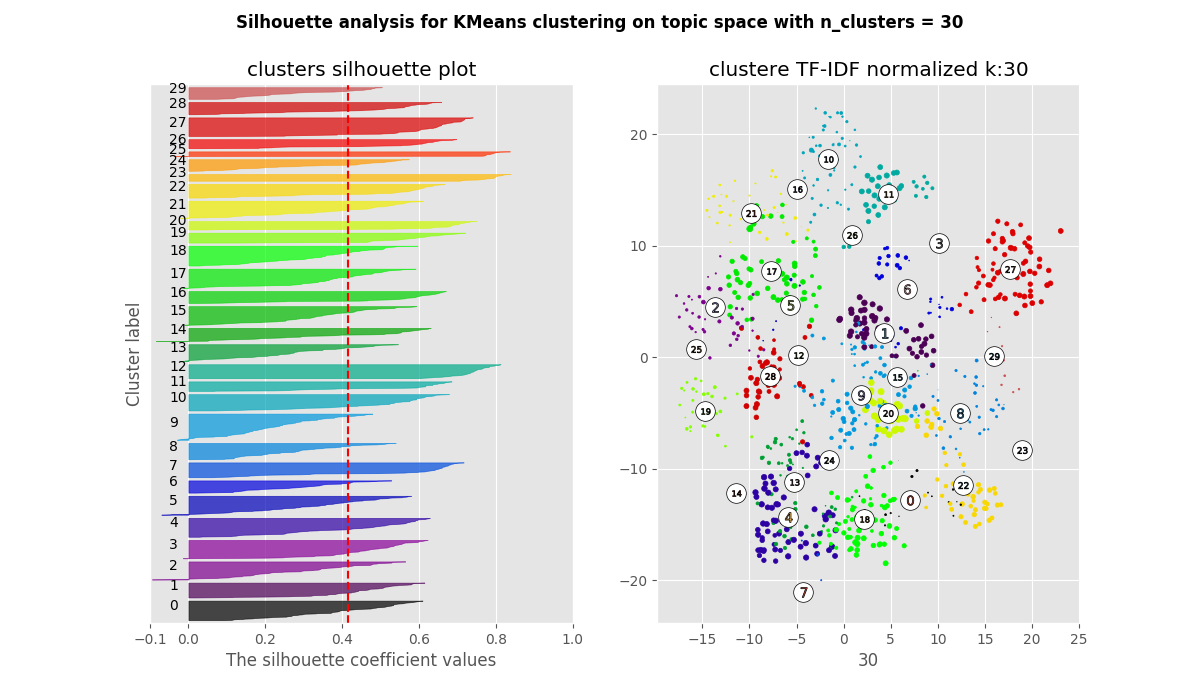

For n_clusters = 30 The average silhouette_score is : 0.415405135063


/usr/local/lib/python3.5/dist-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<IPython.core.display.Javascript object>


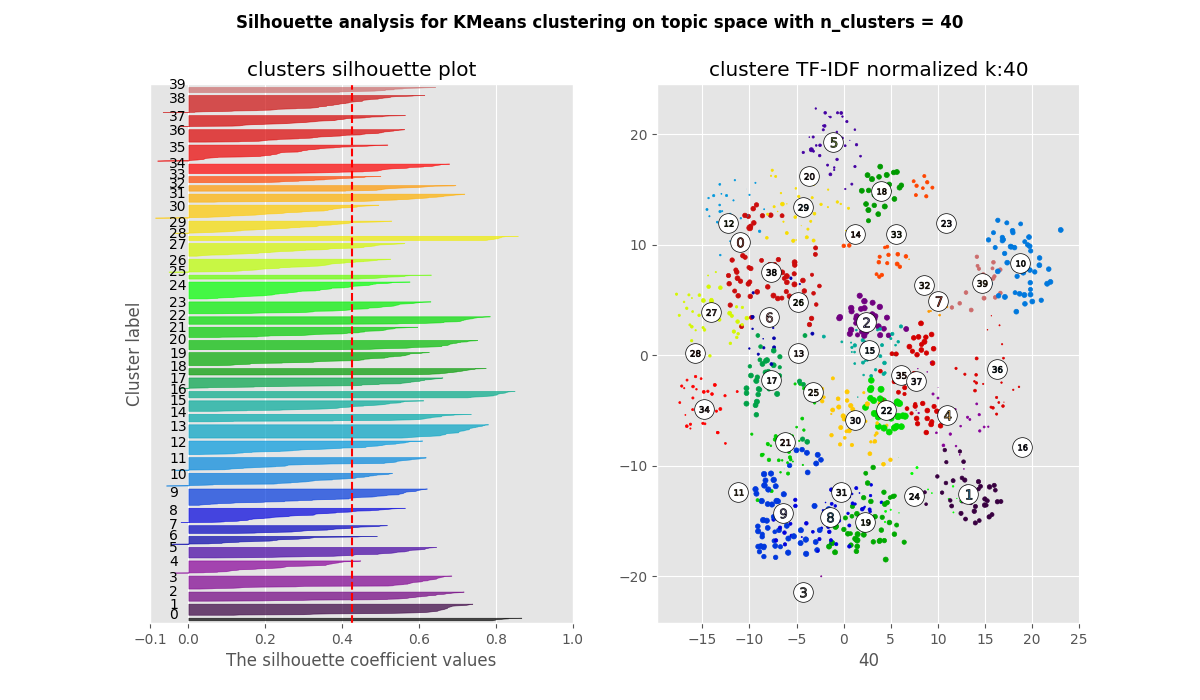

For n_clusters = 40 The average silhouette_score is : 0.425917020388


<IPython.core.display.Javascript object>


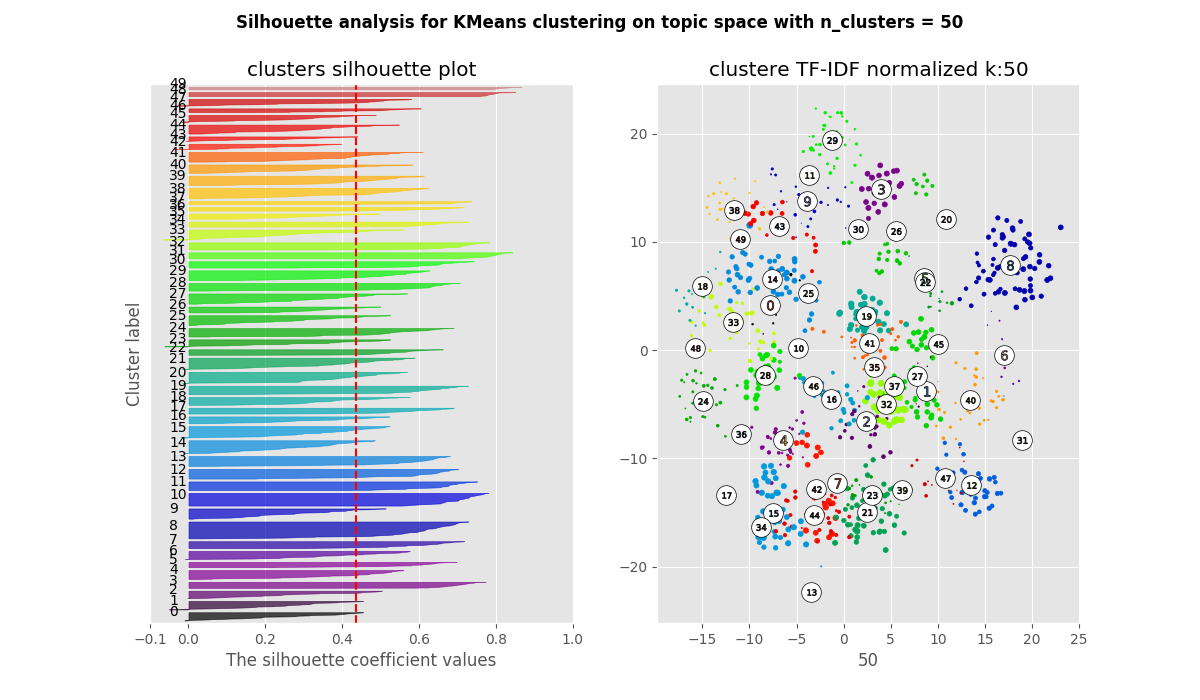

For n_clusters = 50 The average silhouette_score is : 0.437178245572


<IPython.core.display.Javascript object>


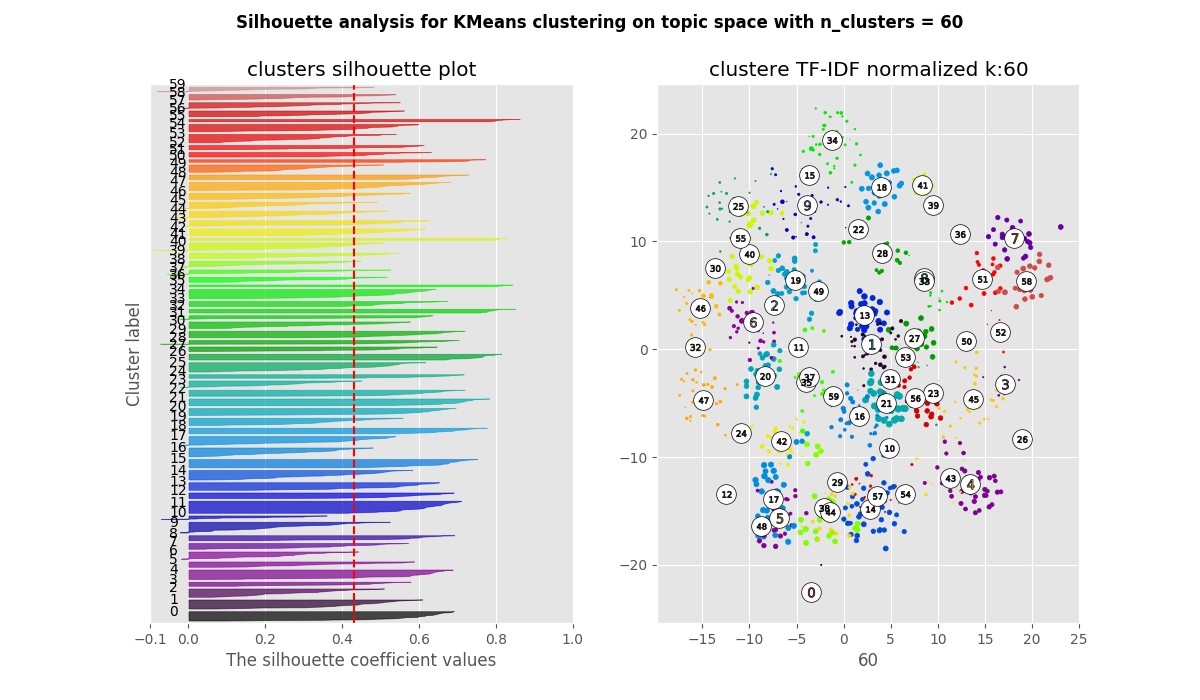

For n_clusters = 60 The average silhouette_score is : 0.431400422075


<IPython.core.display.Javascript object>


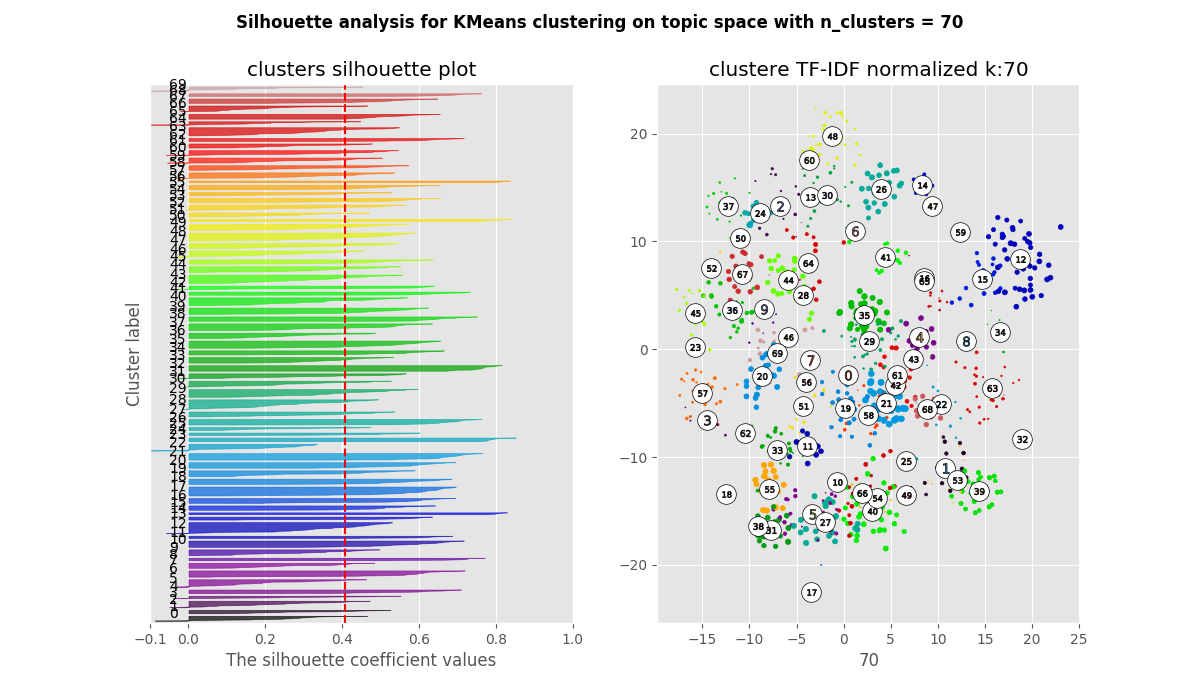

For n_clusters = 70 The average silhouette_score is : 0.408497924998
best number of clusters: 50


0         1         2        3       4  \
0  tf_idf_tokenized_window_2012_11_01         js       fjs       id    type   
1  tf_idf_tokenized_window_2012_11_02     syrian     syria      say  turkey   
2  tf_idf_tokenized_window_2012_11_03   shelling  damascus  suburbs  regime   
3  tf_idf_tokenized_window_2012_11_04     israel      gaza  israeli   hamas   
4  tf_idf_tokenized_window_2012_11_05       news       com     http     www   

             5             6             7           8            9  \
0         href          name         rferl    cssclass  link_button   
1        assad    opposition        rebels     turkish        rebel   
2        daraa        fierce  neighborhood     martyrs    artillery   
3  palestinian  palestinians          arab  gaza_strip          say   
4           in        killed          iraq        html        world   

           ...                         28         29               30  \
0          ...           gulnara_karimova   document              hah   
1          ...                       army   activist           people   
2          ...                     mortar        due             free   
3          ...                   conflict  netanyahu        ceasefire   
4          ...                     google      wound  facebook_reddit   

  label_w2v_no label_w2v_scale label_w2v_normalize label_wmd_distance  \
0           36               6                  25                 25   
1           20               3                  20                 35   
2           14              27                  21                 26   
3            8              19                   7                 11   
4           34              14                  21                  2   

  label_wmd_normalize label_wmd_scale label_tfidf_normalize  
0                  16              60                    45  
1                   6              60                    15  
2                   7              60                    43  
3                   2              60                    10  
4                  22              60                     9  

[5 rows x 38 columns]

CPU times: user 1min 34s, sys: 11.6 s, total: 1min 46s
Wall time: 1min 34s


In [20]:
%%time


# Normalized 
X_tfidf_normalized = preprocessing.normalize(X_tfidf, norm='l2')

# LSA
X_tfidf_normalized = decomposition.TruncatedSVD(n_components=50).fit_transform(X_tfidf_normalized)

X_tfidf_normalized = TSNE(n_components=3, init='pca', verbose=2).fit_transform(X_tfidf_normalized)

best_k, bestlabels = analyze(X_tfidf_normalized, figName="TF-IDF normalized")
print('best number of clusters: %s' % best_k)
df['label_tfidf_normalize'] = bestlabels
display(df.head())

In [21]:
display(df.loc[df['label_tfidf_normalize'] == 7])

0            1                 2  \
43    tf_idf_tokenized_window_2013_03_34   afghanistan          military   
82    tf_idf_tokenized_window_2012_03_13        afghan       afghanistan   
206   tf_idf_tokenized_window_2013_11_09        karzai            afghan   
229   tf_idf_tokenized_window_2013_11_32            us             obama   
256   tf_idf_tokenized_window_2012_04_25   afghanistan            afghan   
285   tf_idf_tokenized_window_2016_12_28        mattis           general   
447   tf_idf_tokenized_window_2012_01_20            us          military   
520   tf_idf_tokenized_window_2017_06_35   afghanistan           taliban   
592   tf_idf_tokenized_window_2012_02_23            us       afghanistan   
595   tf_idf_tokenized_window_2014_08_02         obama               say   
667   tf_idf_tokenized_window_2012_05_08   afghanistan            afghan   
737   tf_idf_tokenized_window_2014_06_04            us              iraq   
757   tf_idf_tokenized_window_2014_09_02         obama              will   
846   tf_idf_tokenized_window_2016_07_29   afghanistan            afghan   
859   tf_idf_tokenized_window_2013_05_06         obama             yemen   
889   tf_idf_tokenized_window_2015_12_14       taliban           mansour   
894   tf_idf_tokenized_window_2015_12_19         obama  president_barack   
990   tf_idf_tokenized_window_2016_06_23       taliban       afghanistan   
1011  tf_idf_tokenized_window_2015_11_12         obama             troop   
1038  tf_idf_tokenized_window_2014_05_13         obama                us   
1183  tf_idf_tokenized_window_2017_03_08            us             trump   
1223  tf_idf_tokenized_window_2014_02_20         hagel            budget   
1237  tf_idf_tokenized_window_2014_02_34        afghan           taliban   
1311  tf_idf_tokenized_window_2016_05_04       taliban           mansour   
1340  tf_idf_tokenized_window_2013_10_05            us       afghanistan   
1403  tf_idf_tokenized_window_2016_02_16       taliban       afghanistan   
1513  tf_idf_tokenized_window_2012_09_18        afghan       afghanistan   

                3              4               5            6              7  \
43       soldiers         afghan         violent       combat            say   
82        soldier             us           bales          say        taliban   
206   afghanistan          troop           jirga         sign           pact   
229      military     washington        american          war         policy   
256            us       pakistan            nato        kabul          obama   
285       defense      secretary        military       retire          kelly   
447         obama    afghanistan           china      defense       strategy   
520        afghan      tora_bora        pakistan        troop          kabul   
592        afghan       pakistan         taliban         nato       military   
595      military             us     white_house         iraq          syria   
667         obama        taliban           troop          war          kabul   
737         obama            say        military        iraqi          troop   
757           say  islamic_state       president  white_house       congress   
846         kabul        taliban          hazara        obama          troop   
859         drone   drone_strike      guantanamo     detainee            say   
889        afghan         mullah     afghanistan     pakistan         akhtar   
894   oval_office         threat  san_bernardino   california  islamic_state   
990        afghan       pakistan           kabul      mansour   drone_strike   
1011      special     deployment              us       ground          syria   
1038  afghanistan          jarba          syrian   washington      coalition   
1183           mr   donald_trump       president     military       pentagon   
1223     military       pentagon            army      defense       spending   
1237  afghanistan         karzai        pakistan      release         b

In [22]:
df.to_csv('data/windowbin/csv/result_all_dynamic_topic.csv')